## 데이터 전처리

### (1) 가격 + 수급안정화지수 + 재고량

In [661]:
import pandas as pd
from scipy import stats
import numpy as np

In [662]:
# 데이터 불러오기
price_data = pd.read_excel('니켈+가격_monthly.xls', skiprows=9)
stability_index_data = pd.read_excel('니켈+수급안정화지수2024-06-10.xls',skiprows=2)


# 필요 없는 데이터 삭제
price_data.drop(price_data.columns[[0,6,7,8,9]], axis=1, inplace=True)
stability_index_data.drop(stability_index_data.columns[0], axis=1, inplace=True)


# 기준일 컬럼 데이터 날짜로 변경
price_data['기준일'] = pd.to_datetime(price_data['기준일'])
stability_index_data['기준일'] = stability_index_data['기준일'].astype(str).apply(lambda x: f"{x[:4]}-{x[4:]}")
stability_index_data['기준일'] = pd.to_datetime(stability_index_data['기준일'])

# 기간 설정
price_data = price_data[(price_data['기준일']>='2017-01-01') & (price_data['기준일']<'2024-01-01')]


# # 데이터 병합
df_nickel = pd.merge(price_data, stability_index_data, on='기준일')



In [663]:
df_nickel

,기준일,기준가격,등락가,등락비율,재고량,수급안정화지수,전월대비 등락가,전월대비 등락율
0,2017-01-01,9984.29,-1028.96,-9.34,374047,NaN,0.00,0.00
1,2017-02-01,10619.50,635.21,6.36,381745,78.24,0.00,0.00
2,2017-03-01,10230.43,-389.07,-3.66,381883,74.56,-3.68,-4.70
3,2017-04-01,9668.61,-561.82,-5.49,375819,77.10,2.54,3.41
4,2017-05-01,9154.29,-514.32,-5.32,380589,80.06,2.96,3.84
...,...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,-400.60,-1.92,37074,28.00,-1.55,-5.26
80,2023-09-01,19629.05,-868.68,-4.24,39516,30.97,2.97,10.62
81,2023-10-01,18255.23,-1373.82,-7.00,43572,31.98,1.01,3.26
82,2023-11-01,16979.77,-1275.46,-6.99,43515,41.74,9.76,30.53


In [664]:
df_nickel.drop(df_nickel.columns[[2,3,6,7]], axis=1, inplace=True)

In [665]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수
0,2017-01-01,9984.29,374047,NaN
1,2017-02-01,10619.50,381745,78.24
2,2017-03-01,10230.43,381883,74.56
3,2017-04-01,9668.61,375819,77.10
4,2017-05-01,9154.29,380589,80.06
...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00
80,2023-09-01,19629.05,39516,30.97
81,2023-10-01,18255.23,43572,31.98
82,2023-11-01,16979.77,43515,41.74


In [666]:
# 원/달러 환율 데이터
er_m = pd.read_csv('exchangerate_monthly.csv', encoding='euc-kr')
er_m = er_m[er_m.columns[[0,4]]]

er_m.rename(columns={'Date':'기준일', 'Close':'환율'},inplace=True)
er_m['기준일'] = pd.to_datetime(er_m['기준일'])

In [667]:
er_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     84 non-null     datetime64[ns]
 1   환율      84 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


In [668]:
er_m

,기준일,환율
0,2017-01-01,1169.209961
1,2017-02-01,1133.939941
2,2017-03-01,1117.020020
3,2017-04-01,1135.640015
4,2017-05-01,1123.900024
...,...,...
79,2023-08-01,1323.030029
80,2023-09-01,1351.930054
81,2023-10-01,1348.069946
82,2023-11-01,1288.359985


In [669]:
# 첫 번째 NaN => 2017년 1월 1일 기준가격과 유사한 3개월치(17년 2월-4월) 수급안정화지수의 평균값으로 대체
mean_value = df_nickel.loc[1:3, '수급안정화지수'].mean()
df_nickel.loc[0, '수급안정화지수'] = round(mean_value, 2)

In [670]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수
0,2017-01-01,9984.29,374047,76.63
1,2017-02-01,10619.50,381745,78.24
2,2017-03-01,10230.43,381883,74.56
3,2017-04-01,9668.61,375819,77.10
4,2017-05-01,9154.29,380589,80.06
...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00
80,2023-09-01,19629.05,39516,30.97
81,2023-10-01,18255.23,43572,31.98
82,2023-11-01,16979.77,43515,41.74


In [671]:
df_nickel = pd.merge(df_nickel, er_m, how='left', on='기준일')

In [672]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율
0,2017-01-01,9984.29,374047,76.63,1169.209961
1,2017-02-01,10619.50,381745,78.24,1133.939941
2,2017-03-01,10230.43,381883,74.56,1117.020020
3,2017-04-01,9668.61,375819,77.10,1135.640015
4,2017-05-01,9154.29,380589,80.06,1123.900024
...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029
80,2023-09-01,19629.05,39516,30.97,1351.930054
81,2023-10-01,18255.23,43572,31.98,1348.069946
82,2023-11-01,16979.77,43515,41.74,1288.359985


### (2) 생산량 + 소비현황

In [673]:
# 데이터 불러오기
production_data = pd.read_csv('광종별국가별생산량.csv', encoding='euc-kr')
consumption_data = pd.read_csv('광종별 소비현황_20231231.csv', encoding='euc-kr')

# 필요없는 데이터 제거
production_data = production_data[(production_data['광종']=='니켈') & (production_data['품목']=='refined')]
# 소비현황 데이터에 refined만 있으므로 생산량 데이터에서 nickel refined만 가져오기
consumption_data = consumption_data[consumption_data['광종']=='니켈']


In [674]:
# 필요없는 컬럼 제거
production_data.drop(production_data.columns[[0,1,2,3,4]], axis=1, inplace=True)

# 행열전환
production_data = production_data.T

# 연도별 합계 계산해서 데이터프레임 생성
production_data= production_data.sum(axis=1).to_frame(name='생산량')

# 인덱스 이름 연도(숫자)만 나오게 변경
production_data.index = production_data.index.str.replace(' 생산량', '')

In [675]:
# 인덱스 컬럼으로 변경, '연도'로 이름 변경
production_data.reset_index(inplace=True)
production_data.columns = ['연도', '생산량']

In [676]:
# 필요없는 컬럼 제거
consumption_data.drop(consumption_data.columns[[0,1,2,3,4]], axis=1, inplace=True)

# 행열전환
consumption_data = consumption_data.T

# 연도별 합계 계산해서 데이터프레임 생성
consumption_data= consumption_data.sum(axis=1).to_frame(name='소비량')

# 인덱스 이름 연도(숫자)만 나오게 변경
consumption_data.index = consumption_data.index.str.replace(' 소비량', '')

In [677]:
# 인덱스 컬럼으로 변경, '연도'로 이름 변경
consumption_data.reset_index(inplace=True)
consumption_data.columns = ['연도', '소비량']

In [678]:
consumption_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연도      13 non-null     object 
 1   소비량     13 non-null     float64
dtypes: float64(1), object(1)
memory usage: 336.0+ bytes


In [679]:
production_consumption = pd.merge(production_data, consumption_data, on='연도')

In [680]:
production_consumption['연도'] = production_consumption['연도'].astype('int')

In [681]:
# 2017년부터 2023년 데이터만 필요
production_consumption = production_consumption[production_consumption['연도']>=2017]
production_consumption.reset_index(drop=True, inplace=True)

In [682]:
production_consumption

,연도,생산량,소비량
0,2017,2065.960,2090.518
1,2018,2251.992,2339.103
2,2019,2430.243,2430.139
3,2020,2528.167,2442.837
4,2021,2784.683,2962.181
5,2022,3089.143,3003.505
6,2023,3429.284,3171.547


In [683]:
import numpy as np

df_nickel['생산량'] = np.nan
df_nickel['소비량'] = np.nan

In [684]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
0,2017-01-01,9984.29,374047,76.63,1169.209961,NaN,NaN
1,2017-02-01,10619.50,381745,78.24,1133.939941,NaN,NaN
2,2017-03-01,10230.43,381883,74.56,1117.020020,NaN,NaN
3,2017-04-01,9668.61,375819,77.10,1135.640015,NaN,NaN
4,2017-05-01,9154.29,380589,80.06,1123.900024,NaN,NaN
...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029,NaN,NaN
80,2023-09-01,19629.05,39516,30.97,1351.930054,NaN,NaN
81,2023-10-01,18255.23,43572,31.98,1348.069946,NaN,NaN
82,2023-11-01,16979.77,43515,41.74,1288.359985,NaN,NaN


In [685]:
# 생산량과 소비량을 연도별로 월 단위로 나누어서 할당

for i, r in df_nickel.iterrows():
    year = r['기준일'].year
    
    for idx, row in production_consumption.iterrows():
        if row['연도']==year:
            df_nickel.iloc[i, 5] = round(row['생산량']/12, 2)
            df_nickel.iloc[i, 6] = round(row['소비량']/12, 2)

In [686]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
0,2017-01-01,9984.29,374047,76.63,1169.209961,172.16,174.21
1,2017-02-01,10619.50,381745,78.24,1133.939941,172.16,174.21
2,2017-03-01,10230.43,381883,74.56,1117.020020,172.16,174.21
3,2017-04-01,9668.61,375819,77.10,1135.640015,172.16,174.21
4,2017-05-01,9154.29,380589,80.06,1123.900024,172.16,174.21
...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029,285.77,264.30
80,2023-09-01,19629.05,39516,30.97,1351.930054,285.77,264.30
81,2023-10-01,18255.23,43572,31.98,1348.069946,285.77,264.30
82,2023-11-01,16979.77,43515,41.74,1288.359985,285.77,264.30


In [687]:
df_nickel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   기준일      84 non-null     datetime64[ns]
 1   기준가격     84 non-null     float64       
 2   재고량      84 non-null     int64         
 3   수급안정화지수  84 non-null     float64       
 4   환율       84 non-null     float64       
 5   생산량      84 non-null     float64       
 6   소비량      84 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.7 KB


In [688]:
df_nickel.describe()

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
count,84,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,2020-06-16 01:08:34.285714176,16689.513571,193718.738095,39.705476,1173.638280,221.184286,219.522857
min,2017-01-01 00:00:00,8930.680000,37074.000000,6.240000,0.115380,172.160000,174.210000
25%,2018-09-23 12:00:00,12477.230000,72929.250000,16.585000,1119.762543,187.670000,194.930000
50%,2020-06-16 00:00:00,15209.440000,206399.000000,38.860000,1168.534973,210.680000,203.570000
75%,2022-03-08 18:00:00,19990.800000,255798.500000,60.375000,1230.577515,257.430000,250.290000
max,2023-12-01 00:00:00,33298.420000,385273.000000,82.860000,1430.170044,285.770000,264.300000
std,NaN,5534.406269,114615.840014,24.056437,155.689197,37.233159,31.585517


In [689]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.dates as mdates

plt.rc('font', family='Malgun Gothic')
%matplotlib inline

matplotlib.rcParams['axes.unicode_minus']=False

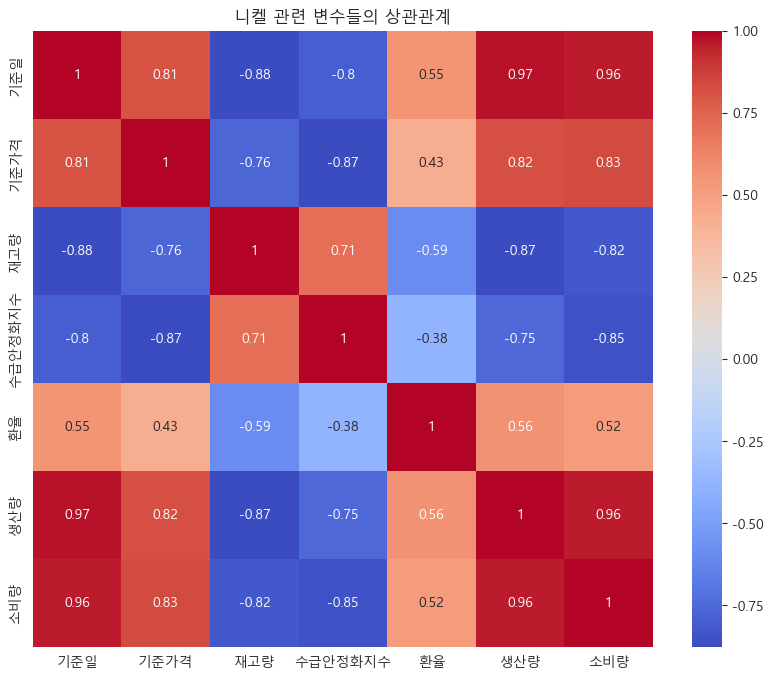

In [690]:

plt.figure(figsize=(10, 8))
sns.heatmap(df_nickel.corr(), annot=True, cmap='coolwarm')
plt.title('니켈 관련 변수들의 상관관계')
plt.show()

소비량과 생산량이 클수록, 수급안정화지수와 LME(London Metal Exchange) 재고량이 낮을수록 가격이 높아짐

Text(0, 0.5, 'price')

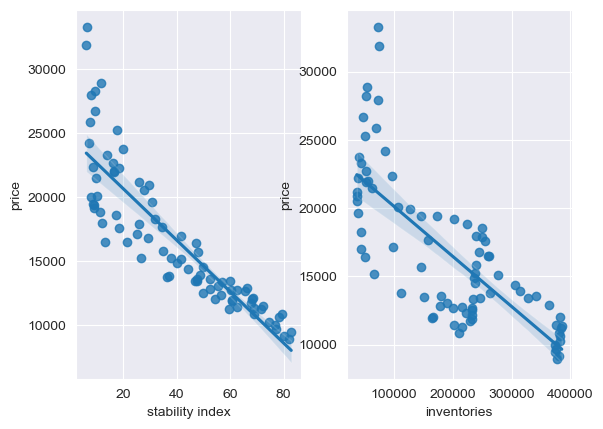

In [691]:
# 수급안정화지수과 재고량과 가격의 관계 관찰

sns.set_style('darkgrid')
sns.set_style(rc={'figure.figsize':(12,6)})

fig, ax = plt.subplots(ncols=2)
sns.regplot(x='수급안정화지수', y='기준가격', data=df_nickel, ax=ax[0])
ax[0].set_xlabel('stability index')
ax[0].set_ylabel('price')

sns.regplot(x='재고량', y='기준가격', data=df_nickel, ax=ax[1])
ax[1].set_xlabel('inventories')
ax[1].set_ylabel('price')

---

## 데이터 전처리

In [692]:
df_nickel

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
0,2017-01-01,9984.29,374047,76.63,1169.209961,172.16,174.21
1,2017-02-01,10619.50,381745,78.24,1133.939941,172.16,174.21
2,2017-03-01,10230.43,381883,74.56,1117.020020,172.16,174.21
3,2017-04-01,9668.61,375819,77.10,1135.640015,172.16,174.21
4,2017-05-01,9154.29,380589,80.06,1123.900024,172.16,174.21
...,...,...,...,...,...,...,...
79,2023-08-01,20497.73,37074,28.00,1323.030029,285.77,264.30
80,2023-09-01,19629.05,39516,30.97,1351.930054,285.77,264.30
81,2023-10-01,18255.23,43572,31.98,1348.069946,285.77,264.30
82,2023-11-01,16979.77,43515,41.74,1288.359985,285.77,264.30


In [693]:
# interpolate으로 nan값 채우기
df_nickel['환율'] = df_nickel['환율'].interpolate(method='linear')

In [694]:
import numpy as np
from scipy import stats
# 이상치 제거
# Z-score를 사용한 이상치 탐지
z_scores = np.abs(stats.zscore(df_nickel['기준가격']))
threshold = 2.5 # 임계값
z_outliers = (z_scores > threshold)

# 이상치 날짜 리스트 만들기
date_list = []
for i, r in df_nickel[z_outliers].iterrows():
    d = r[0]
    date_list.append(d)

# 해당 날짜 가격 nan으로 대체
for i, r in df_nickel.iterrows():
    if r['기준일'] in date_list:
        df_nickel.at[i, '기준가격'] = np.nan

# 결측치 보간
df_nickel['기준가격'] = df_nickel['기준가격'].interpolate(method='linear').round(2)

In [695]:
date_list

[Timestamp('2022-03-01 00:00:00'), Timestamp('2022-04-01 00:00:00')]

In [696]:
df_nickel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   기준일      84 non-null     datetime64[ns]
 1   기준가격     84 non-null     float64       
 2   재고량      84 non-null     int64         
 3   수급안정화지수  84 non-null     float64       
 4   환율       84 non-null     float64       
 5   생산량      84 non-null     float64       
 6   소비량      84 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.7 KB


In [697]:
df_nickel[df_nickel['기준일'].isin(date_list)]

,기준일,기준가격,재고량,수급안정화지수,환율,생산량,소비량
62,2022-03-01,25435.33,74771,6.24,1210.439941,257.43,250.29
63,2022-04-01,26692.67,73029,6.34,1263.380005,257.43,250.29


## PROPHET

### 함수 생성

In [702]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열 분해 함수

def seasonal_decompose_graph(df, col_name, p):

    # 시계열 분해 (additive 모델 사용)
    print("additive 모델")
    result = seasonal_decompose(df[col_name], model='additive', period=p)  # 월별 데이터일 경우 period=12 (1년 단위)
    result.plot()
    plt.show()

    # 시계열 분해 (multiplicative 모델 사용)
    print("multiplicative 모델")
    result = seasonal_decompose(df[col_name], model='multiplicative', period=p)  # 월별 데이터일 경우 period=12 (1년 단위)
    result.plot()
    plt.show()

In [703]:
# train, test split

def split_train_test(df, col_name):
    df_tmp = df[['기준일', col_name]].rename(columns={'기준일': 'ds', col_name: 'y'})

    # 2. Train/Test Split (80% train, 20% test)
    train_size = int(len(df_tmp) * 0.8)
    train = df_tmp[:train_size]  # 학습 데이터
    test = df_tmp[train_size:]  # 테스트 데이터

    return df_tmp, train, test

In [705]:
# train, test split

def split_train_test_production_consumption(col_name):
    df_tmp = production_consumption[['연도', col_name]].rename(columns={'연도': 'ds', col_name: 'y'})
    df_tmp['ds'] = pd.to_datetime(df_tmp['ds'], format='%Y')

    # 2. Train/Test Split (80% train, 20% test)  
    train_size = int(len(df_tmp) * 0.8)
    train = df_tmp[:train_size]  # 학습 데이터
    test = df_tmp[train_size:]  # 테스트 데이터

    return df_tmp, train, test

In [706]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한국어 폰트 설정 (맑은 고딕 사용)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows에서 '맑은 고딕' 폰트 경로
fontprop = fm.FontProperties(fname=font_path)

# 그래프 시각화 시, 폰트 설정
plt.rc('font', family=fontprop.get_name())

matplotlib.rcParams['axes.unicode_minus']=False

# prophet 예측, 성능 지표, 예측값 시각화
def prophet_metrix_plot(train,test,f):

    # 3. Prophet 모델 생성 및 학습
    model = Prophet()
    model.fit(train)

    # 4. 테스트 기간 예측 수행
    future = model.make_future_dataframe(periods=len(test), freq=f)
    forecast = model.predict(future)

    # 5. 예측 성능 평가 (테스트 데이터에 대해)
    test_forecast = forecast[-len(test):]  # 테스트 기간에 해당하는 예측 값 가져오기

    # 실제 값과 예측 값 준비
    actual = test['y'].values  # 실제 테스트 값
    predicted = test_forecast['yhat'].values  # Prophet의 예측 값

    # 성능 지표 계산
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"MAE (Mean Absolute Error): {mae}")
    print(f"RMSE (Root Mean Squared Error): {rmse}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

    # 예측 결과 시각화
    model.plot(forecast)
    plt.show()

    # 변화점 및 계절성 플롯
    model.plot_components(forecast)
    plt.show()

    # 예측값 시각화
    plt.figure(figsize=(10, 6))

    # 실제 값 시각화 (테스트 데이터)
    plt.plot(test['ds'], actual, label='Actual (Test Data)', color='blue')

    # 예측 값 시각화 (테스트 데이터)
    plt.plot(test['ds'], predicted, label='Predicted (Prophet)', color='orange', linestyle='--')

    # 제목 및 축 레이블
    plt.title('Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel('')
    plt.legend()

    # 그래프 출력
    plt.grid()
    plt.show()
    

In [707]:
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


def tune_prophet_parameters(param_grid, f):
    # 가능한 모든 하이퍼파라미터 조합을 생성
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    best_params = None
    best_rmse = float('inf')

    # Grid Search를 통해 최적의 하이퍼파라미터 찾기
    for params in all_params:
        # Prophet 모델 생성
        model = Prophet(**params)
        model.fit(train)
        
        # 미래 데이터 프레임 생성 및 예측 수행
        future = model.make_future_dataframe(periods=len(test), freq=f)
        forecast = model.predict(future)

        # 테스트 데이터에 대한 예측 값 가져오기
        test_forecast = forecast[-len(test):]
        predicted = test_forecast['yhat'].values

        # RMSE 계산
        actual = test['y'].values
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        # 최적의 하이퍼파라미터 및 RMSE 갱신
        
        if rmse < best_rmse:
            best_params = params
            best_rmse = rmse

    print(f"Best Parameters: {best_params}")
    print(f"Best RMSE: {best_rmse}")
    return best_params

def tune_prophet_parameters_plot(best_params, f):
    # 최적 파라미터를 사용한 모델 생성
    model = Prophet(**best_params)

    # 학습 수행
    model.fit(train)  # train 데이터로 모델 학습

    # 미래 기간에 대한 데이터프레임 생성 (테스트 기간에 해당하는 만큼)
    future = model.make_future_dataframe(periods=len(test), freq=f)

    # 예측 수행
    forecast = model.predict(future)

    # 테스트 기간의 예측 값 가져오기
    test_forecast = forecast[-len(test):]  # 테스트 기간에 해당하는 예측 값

    # 실제 값과 예측 값 준비
    actual = test['y'].values  # 실제 테스트 값
    predicted = test_forecast['yhat'].values  # Prophet의 예측 값

    # 성능 지표 계산
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"MAE (Mean Absolute Error): {mae}")
    print(f"RMSE (Root Mean Squared Error): {rmse}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

    # 예측 결과 시각화
    model.plot(forecast)
    plt.show()

    # 변화점 및 계절성 플롯
    model.plot_components(forecast)
    plt.show()

    # 그래프 설정
    plt.figure(figsize=(10, 6))

    # 실제 값 시각화 (테스트 데이터)
    plt.plot(test['ds'], actual, label='Actual (Test Data)', color='blue')

    # 예측 값 시각화 (테스트 데이터)
    plt.plot(test['ds'], predicted, label='Predicted (Prophet)', color='orange', linestyle='--')

    # 제목 및 축 레이블
    plt.title('Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel('')
    plt.legend()

    # 그래프 출력
    plt.grid()
    plt.show()


In [708]:
def predict_2024(df, p, f, c):
    # 최적 파라미터를 사용한 모델 생성
    model = Prophet(**best_params)

    # 학습 수행
    model.fit(df)  # 전체 데이터로 모델 학습

    # 미래 기간에 대한 데이터프레임 생성
    future = model.make_future_dataframe(periods=p, freq=f)

    # 예측 수행
    forecast = model.predict(future)

    # 테스트 기간의 예측 값 가져오기
    test_forecast = forecast[-p:]  

    # 예측 결과 시각화
    model.plot(forecast)
    plt.show()

    # 변화점 및 계절성 플롯
    model.plot_components(forecast)
    plt.show()

    # 11. 예측 결과만 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'][-p:], forecast['yhat'][-p:], label='Forecasted Data', color=c)
    plt.title('')
    plt.xlabel('Date')
    plt.ylabel('')
    plt.legend()
    plt.grid()
    plt.show()

    return test_forecast

### 니켈 가격

<Axes: >

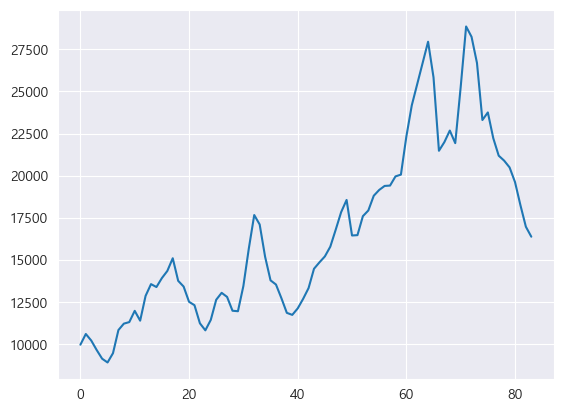

In [165]:
df_nickel['기준가격'].plot()

additive 모델


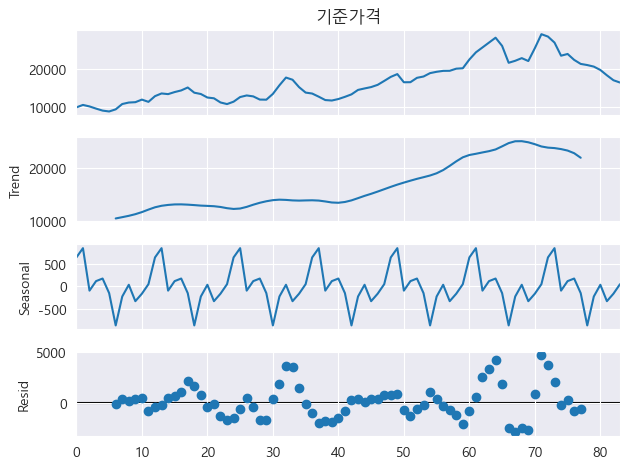

multiplicative 모델


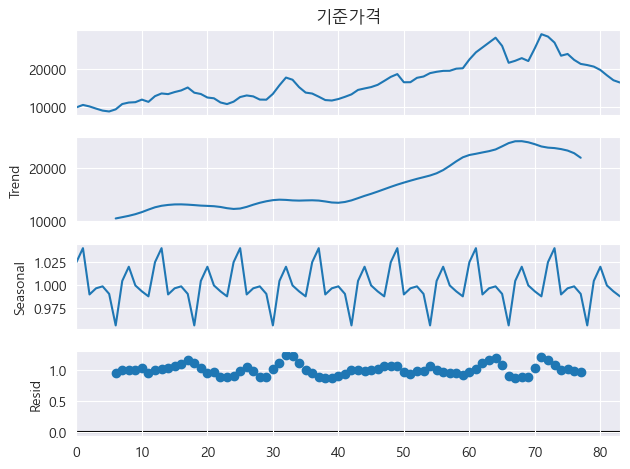

In [549]:
seasonal_decompose_graph(df_nickel, '기준가격', 12)

In [578]:
df_tmp, train, test = split_train_test(df_nickel, '기준가격')

In [579]:
df_tmp

,ds,y
0,2017-01-01,9984.29
1,2017-02-01,10619.50
2,2017-03-01,10230.43
3,2017-04-01,9668.61
4,2017-05-01,9154.29
...,...,...
79,2023-08-01,20497.73
80,2023-09-01,19629.05
81,2023-10-01,18255.23
82,2023-11-01,16979.77


02:58:18 - cmdstanpy - INFO - Chain [1] start processing
02:58:18 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 7166.507941167553
RMSE (Root Mean Squared Error): 8378.856340699665
MAPE (Mean Absolute Percentage Error): 35.35%


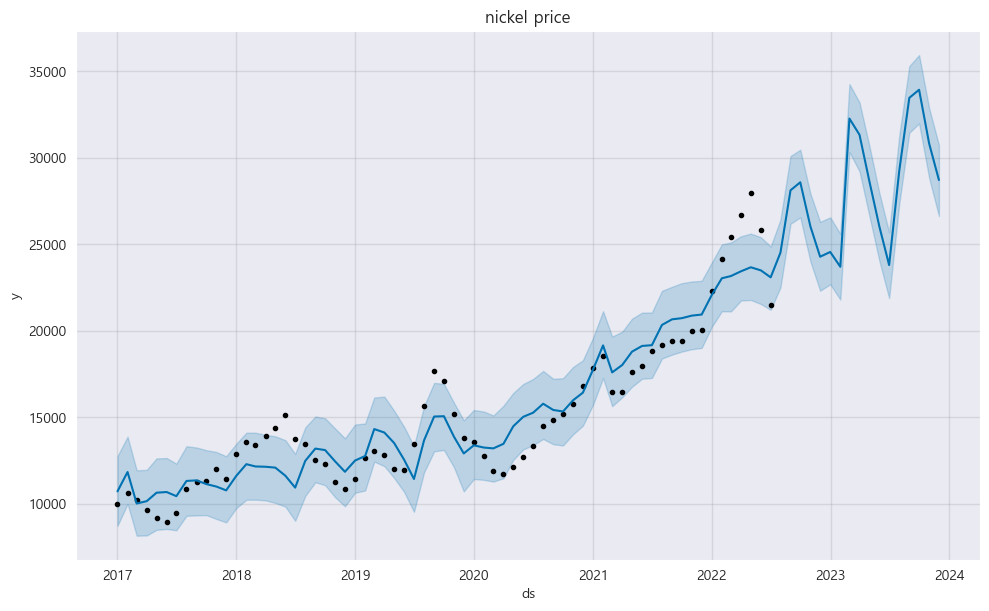

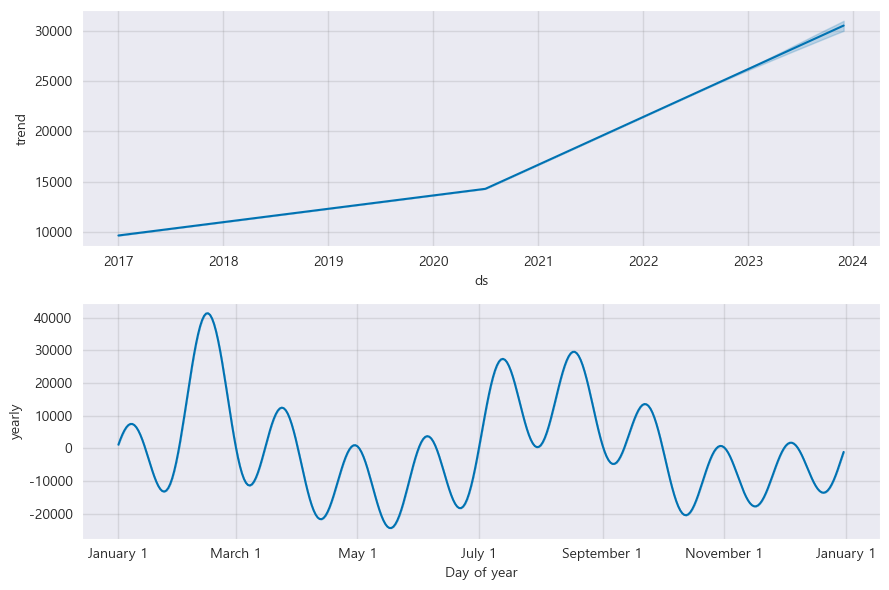

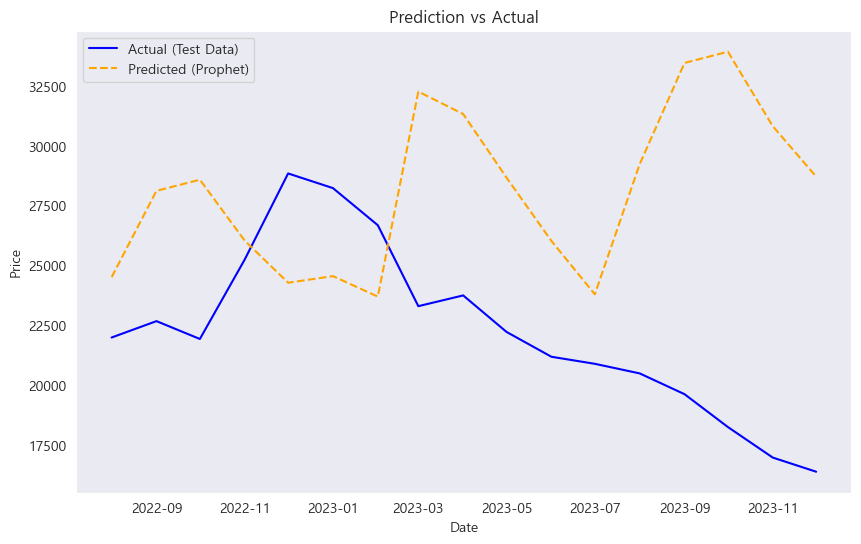

In [562]:
prophet_metrix_plot(train,test,'M')

#### 하이퍼파라미터 튜닝

In [571]:
# Grid Search를 위한 하이퍼파라미터 후보 설정
param_grid = {
    # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 2.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative']  
}

best_params = tune_prophet_parameters(param_grid, 'M')

03:19:03 - cmdstanpy - INFO - Chain [1] start processing
03:19:03 - cmdstanpy - INFO - Chain [1] done processing
03:19:03 - cmdstanpy - INFO - Chain [1] start processing
03:19:03 - cmdstanpy - INFO - Chain [1] done processing
03:19:04 - cmdstanpy - INFO - Chain [1] start processing
03:19:04 - cmdstanpy - INFO - Chain [1] done processing
03:19:04 - cmdstanpy - INFO - Chain [1] start processing
03:19:04 - cmdstanpy - INFO - Chain [1] done processing
03:19:04 - cmdstanpy - INFO - Chain [1] start processing
03:19:04 - cmdstanpy - INFO - Chain [1] done processing
03:19:04 - cmdstanpy - INFO - Chain [1] start processing
03:19:04 - cmdstanpy - INFO - Chain [1] done processing
03:19:05 - cmdstanpy - INFO - Chain [1] start processing
03:19:05 - cmdstanpy - INFO - Chain [1] done processing
03:19:05 - cmdstanpy - INFO - Chain [1] start processing
03:19:05 - cmdstanpy - INFO - Chain [1] done processing
03:19:05 - cmdstanpy - INFO - Chain [1] start processing
03:19:05 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}
Best RMSE: 4101.526126535824


03:19:30 - cmdstanpy - INFO - Chain [1] start processing
03:19:30 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 3243.9772670758243
RMSE (Root Mean Squared Error): 4101.526126535824
MAPE (Mean Absolute Percentage Error): 15.41%


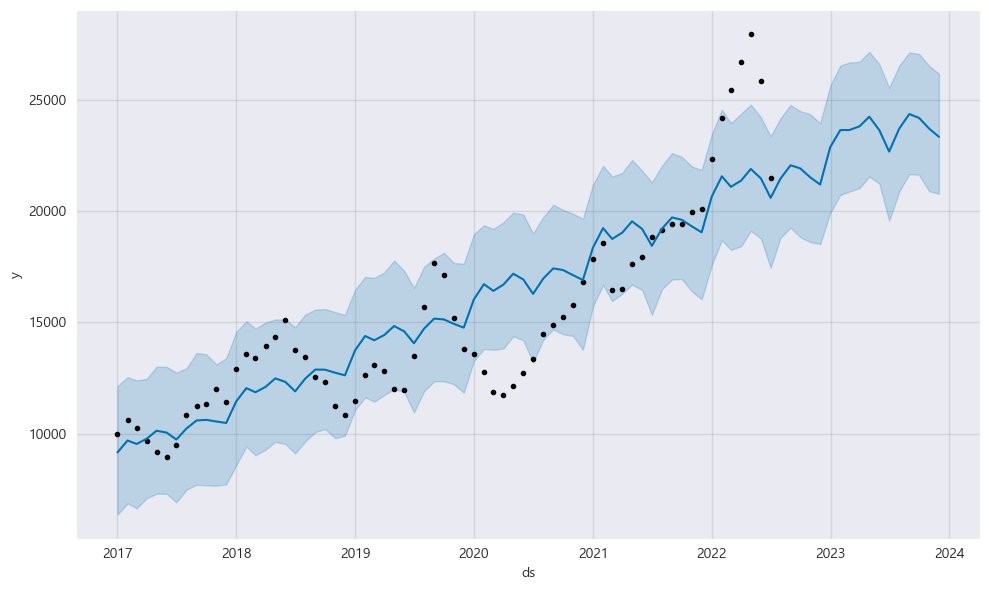

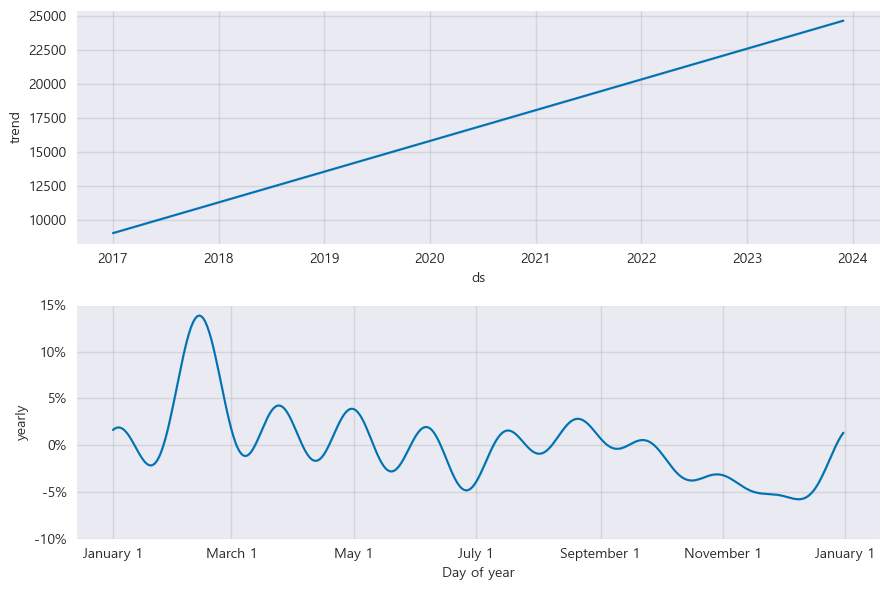

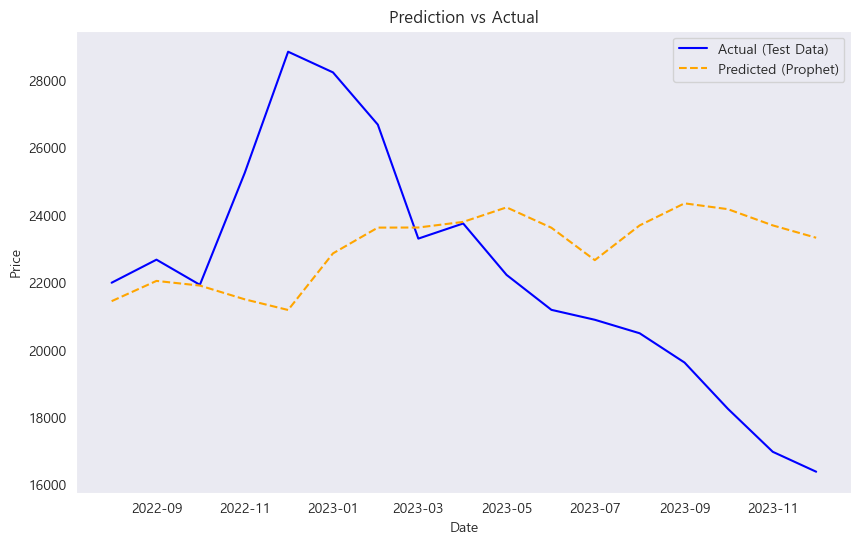

In [572]:
tune_prophet_parameters_plot(best_params, 'M')

#### 예측

03:35:54 - cmdstanpy - INFO - Chain [1] start processing


03:35:55 - cmdstanpy - INFO - Chain [1] done processing


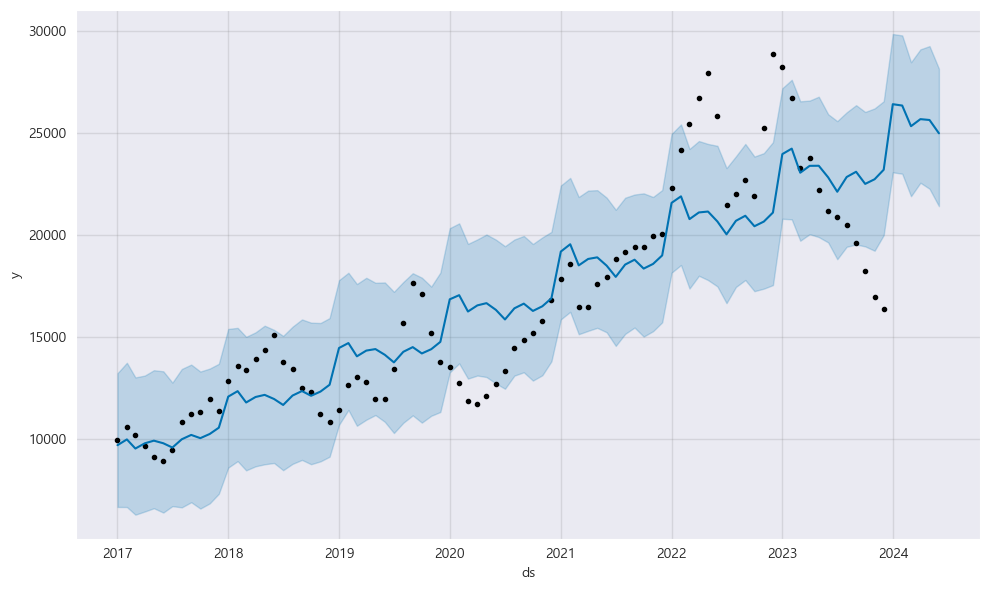

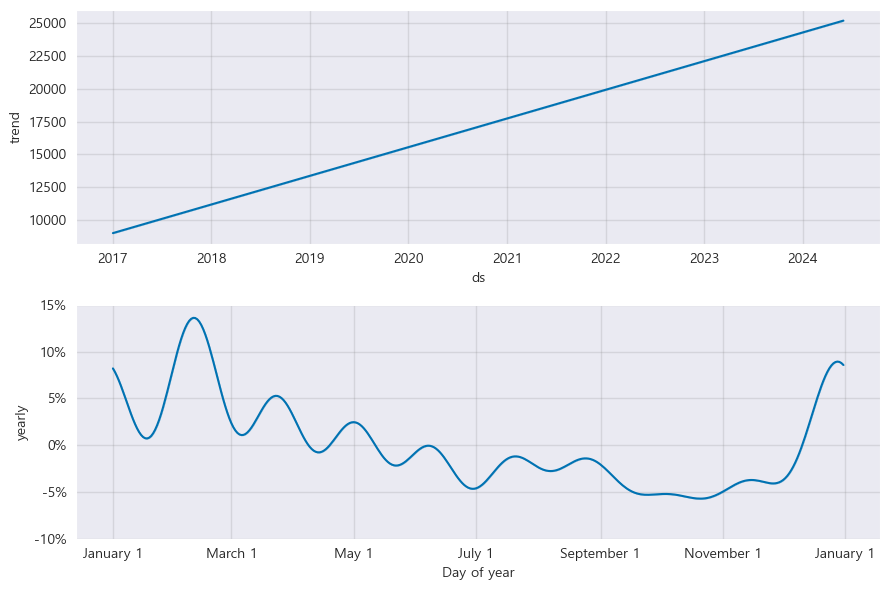

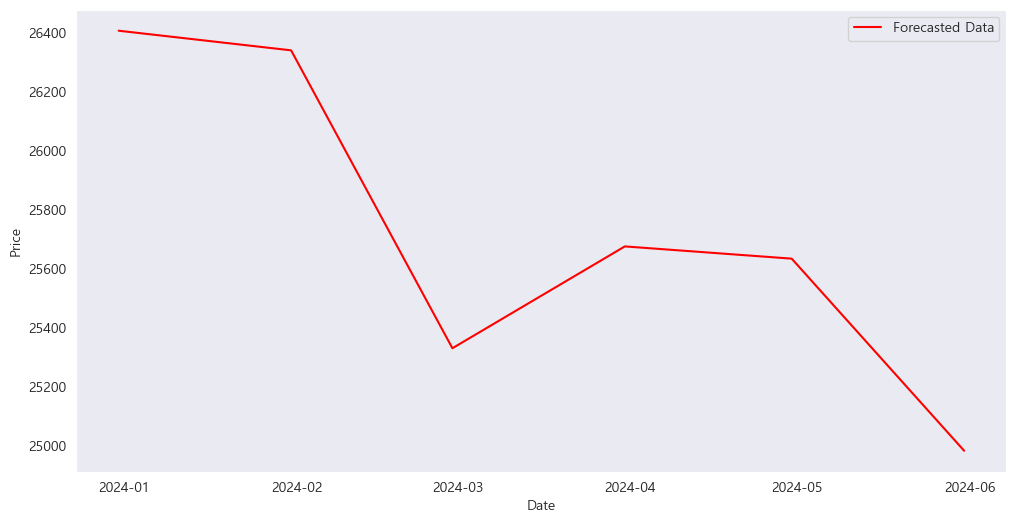

In [583]:
test_forecast = predict_2024(df_tmp, 6, 'M', 'red')

In [585]:
test_forecast[['ds','yhat']]

,ds,yhat
84,2023-12-31,26407.799177
85,2024-01-31,26341.269069
86,2024-02-29,25330.735914
87,2024-03-31,25676.138077
88,2024-04-30,25634.629688
89,2024-05-31,24983.092002


In [593]:
df_2024_forecast = test_forecast[['ds','yhat']]
df_2024_forecast = df_2024_forecast.rename(columns={'yhat':'니켈가격'})

In [594]:
df_2024_forecast

,ds,니켈가격
84,2023-12-31,26407.799177
85,2024-01-31,26341.269069
86,2024-02-29,25330.735914
87,2024-03-31,25676.138077
88,2024-04-30,25634.629688
89,2024-05-31,24983.092002


### 니켈 재고량

<Axes: >

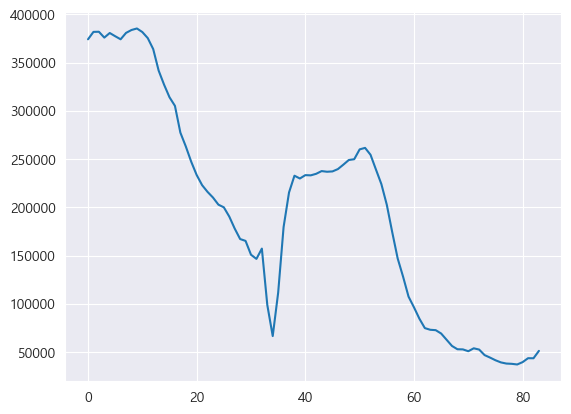

In [595]:
df_nickel['재고량'].plot()

additive 모델


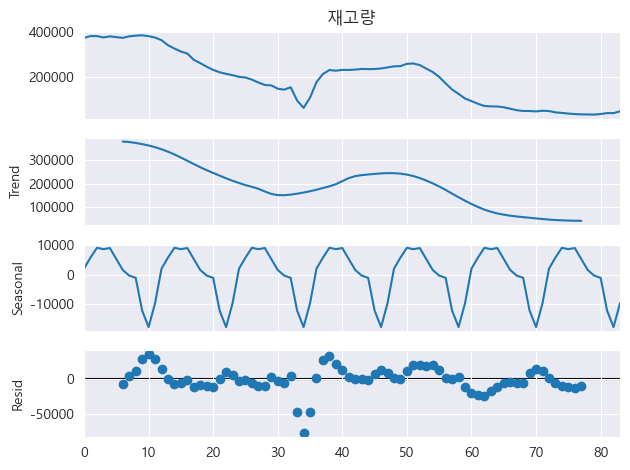

multiplicative 모델


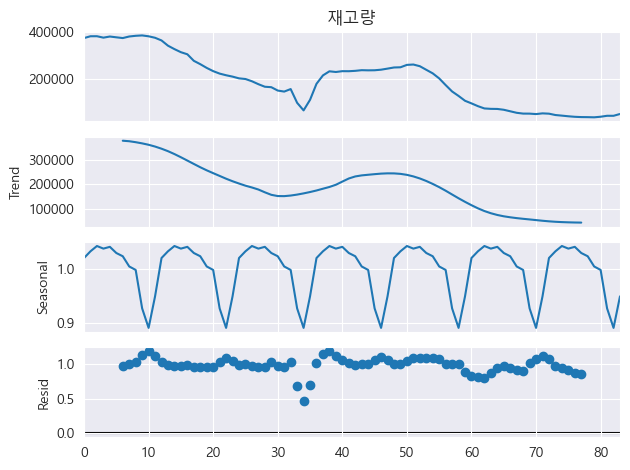

In [596]:
seasonal_decompose_graph(df_nickel, '재고량', 12)

In [597]:
df_tmp, train, test = split_train_test(df_nickel, '재고량')

03:42:19 - cmdstanpy - INFO - Chain [1] start processing
03:42:20 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 46818.997317499845
RMSE (Root Mean Squared Error): 58133.52437149476
MAPE (Mean Absolute Percentage Error): 101.02%


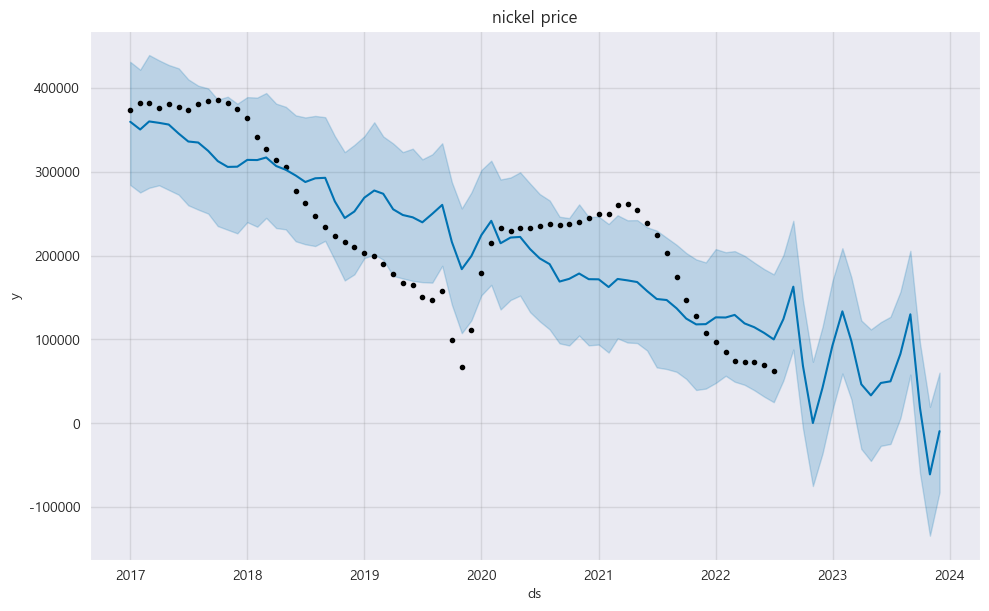

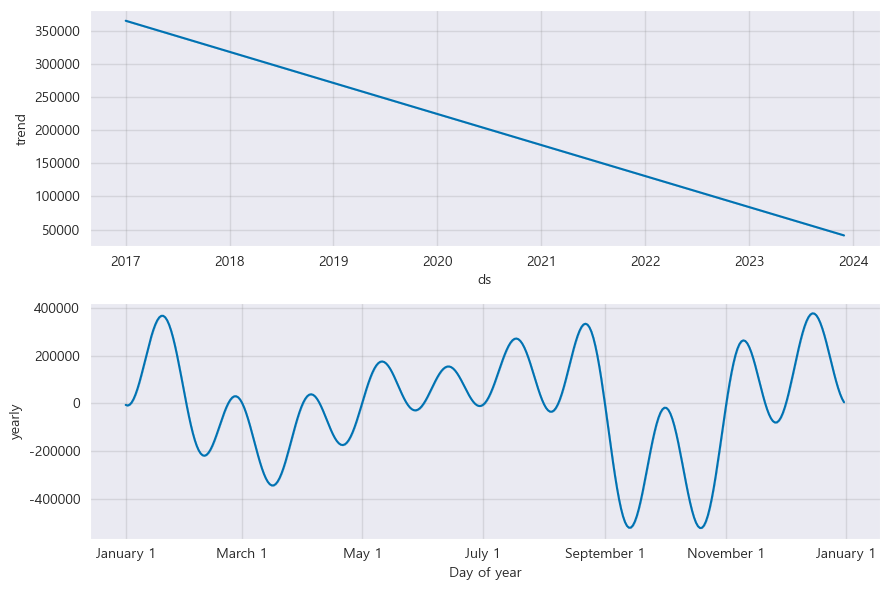

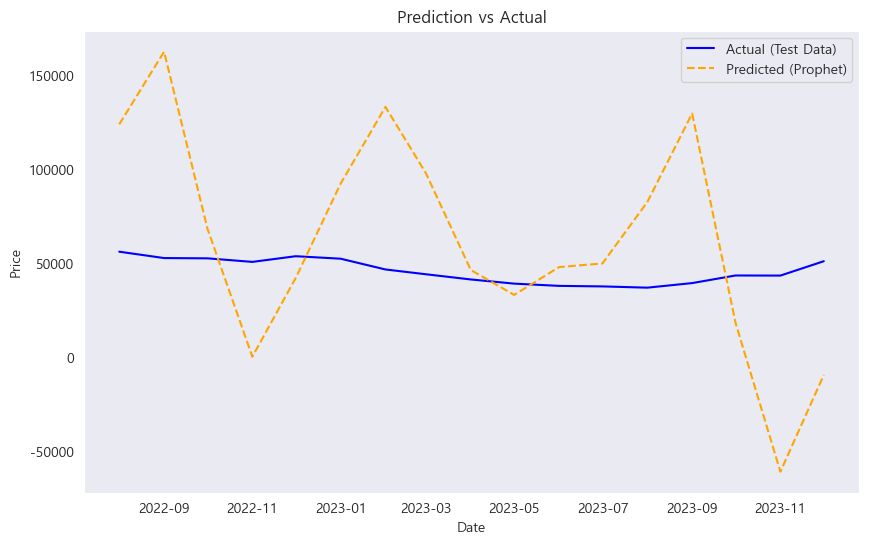

In [601]:
prophet_metrix_plot(train,test,'M')

#### 하이퍼파라미터 튜닝

In [602]:
# Grid Search를 위한 하이퍼파라미터 후보 설정
param_grid = {
    # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 2.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive']  
}

best_params = tune_prophet_parameters(param_grid, 'M')

03:42:58 - cmdstanpy - INFO - Chain [1] start processing
03:42:58 - cmdstanpy - INFO - Chain [1] done processing
03:42:58 - cmdstanpy - INFO - Chain [1] start processing
03:42:59 - cmdstanpy - INFO - Chain [1] done processing
03:42:59 - cmdstanpy - INFO - Chain [1] start processing
03:42:59 - cmdstanpy - INFO - Chain [1] done processing
03:42:59 - cmdstanpy - INFO - Chain [1] start processing
03:42:59 - cmdstanpy - INFO - Chain [1] done processing
03:42:59 - cmdstanpy - INFO - Chain [1] start processing
03:43:00 - cmdstanpy - INFO - Chain [1] done processing
03:43:00 - cmdstanpy - INFO - Chain [1] start processing
03:43:00 - cmdstanpy - INFO - Chain [1] done processing
03:43:00 - cmdstanpy - INFO - Chain [1] start processing
03:43:01 - cmdstanpy - INFO - Chain [1] done processing
03:43:01 - cmdstanpy - INFO - Chain [1] start processing
03:43:01 - cmdstanpy - INFO - Chain [1] done processing
03:43:01 - cmdstanpy - INFO - Chain [1] start processing
03:43:01 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}
Best RMSE: 22066.310141491897


03:43:55 - cmdstanpy - INFO - Chain [1] start processing
03:43:56 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 20028.300444558852
RMSE (Root Mean Squared Error): 22066.310141491897
MAPE (Mean Absolute Percentage Error): 42.30%


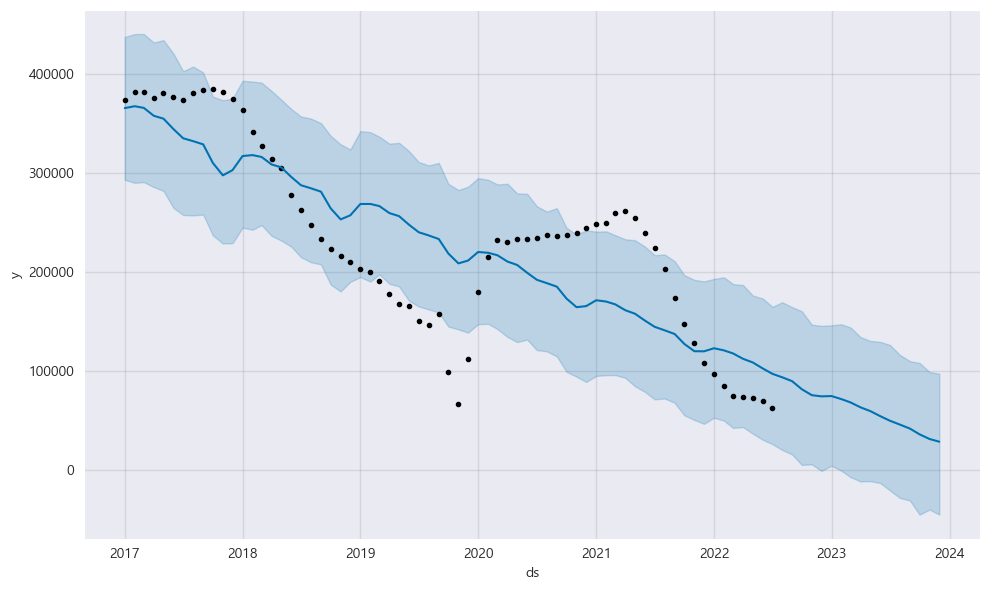

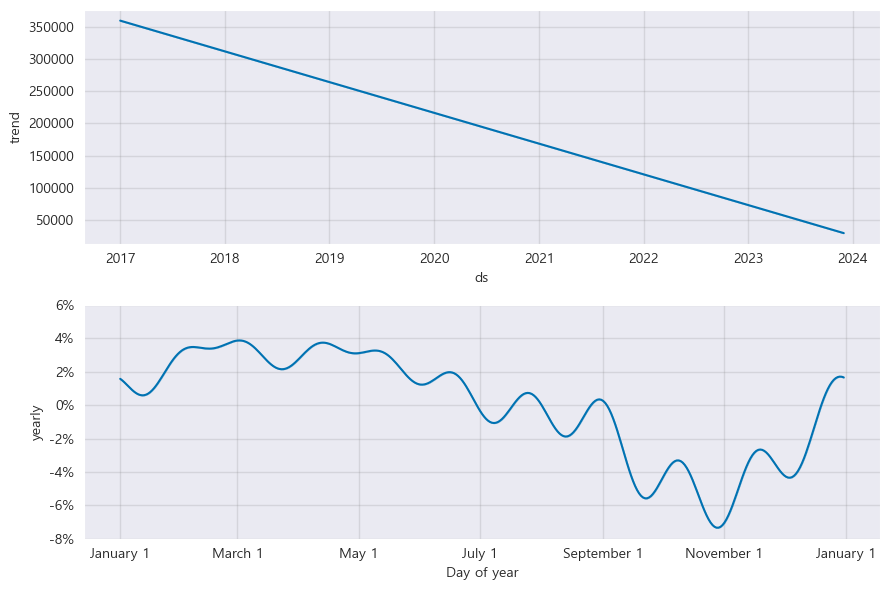

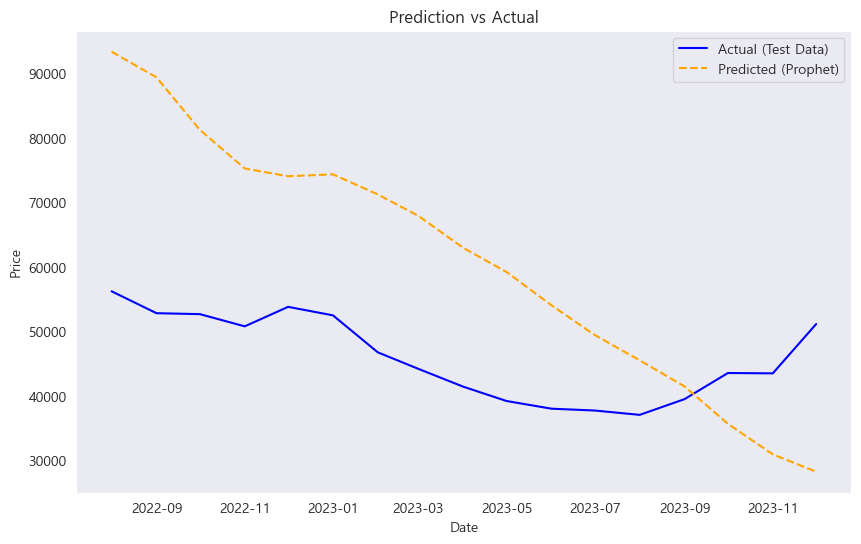

In [603]:
tune_prophet_parameters_plot(best_params, 'M')

#### 예측

03:44:46 - cmdstanpy - INFO - Chain [1] start processing
03:44:47 - cmdstanpy - INFO - Chain [1] done processing


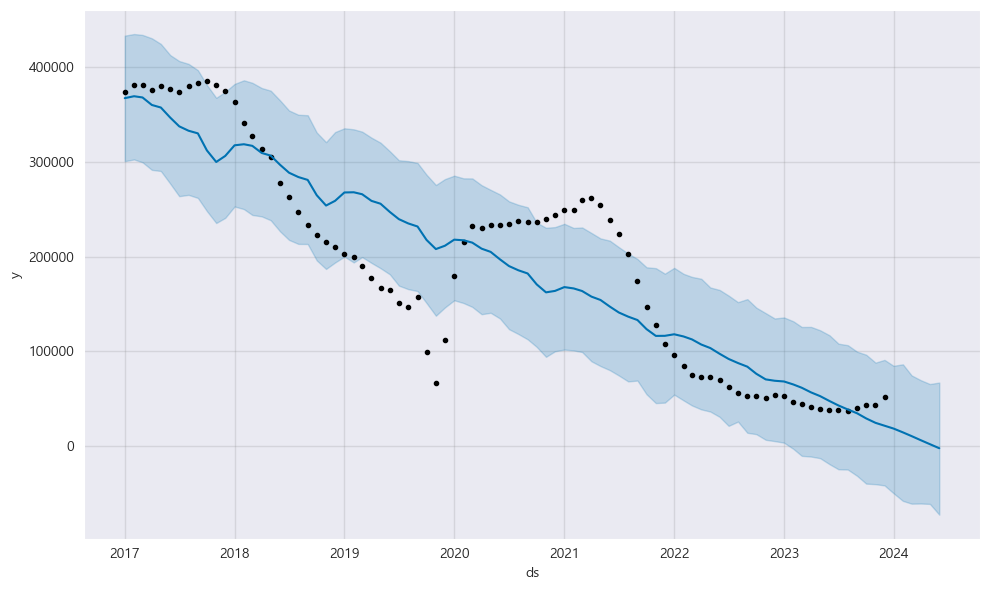

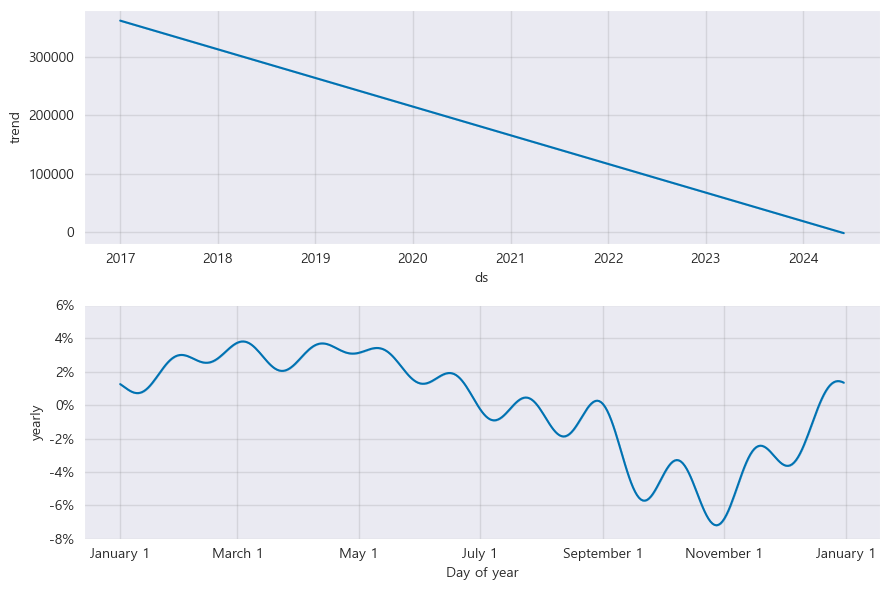

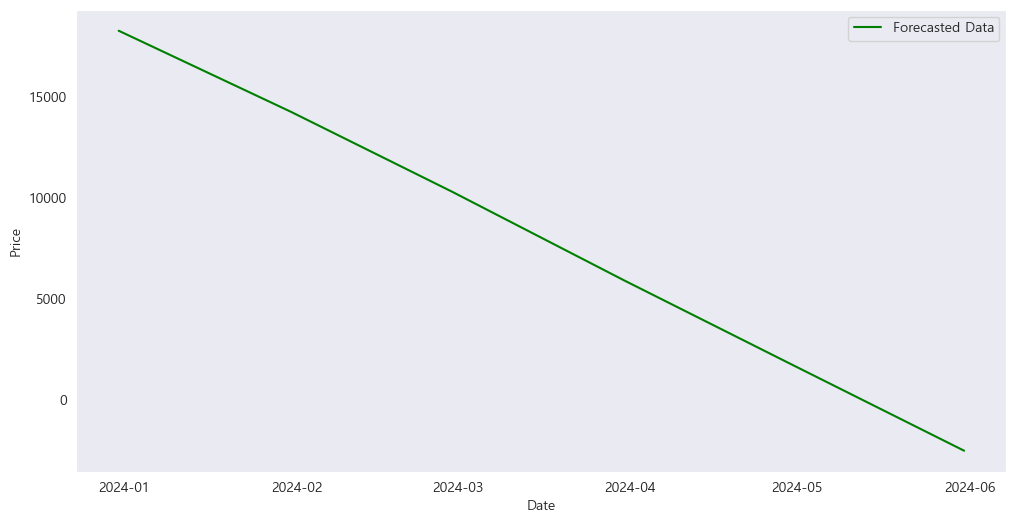

In [604]:
test_forecast = predict_2024(df_tmp, 6, 'M', 'green')

In [605]:
test_forecast[['ds','yhat']]

,ds,yhat
84,2023-12-31,18266.115339
85,2024-01-31,14245.672769
86,2024-02-29,10283.731075
87,2024-03-31,5881.976931
88,2024-04-30,1733.431671
89,2024-05-31,-2537.615999


In [608]:
df_nickel_stock = test_forecast[['ds','yhat']]
df_nickel_stock = df_nickel_stock.rename(columns={'yhat':'재고량'})

In [609]:
df_nickel_stock

,ds,재고량
84,2023-12-31,18266.115339
85,2024-01-31,14245.672769
86,2024-02-29,10283.731075
87,2024-03-31,5881.976931
88,2024-04-30,1733.431671
89,2024-05-31,-2537.615999


In [610]:
df_2024_forecast['재고량'] = df_nickel_stock['재고량']

In [611]:
df_2024_forecast

,ds,니켈가격,재고량
84,2023-12-31,26407.799177,18266.115339
85,2024-01-31,26341.269069,14245.672769
86,2024-02-29,25330.735914,10283.731075
87,2024-03-31,25676.138077,5881.976931
88,2024-04-30,25634.629688,1733.431671
89,2024-05-31,24983.092002,-2537.615999


### 환율

<Axes: >

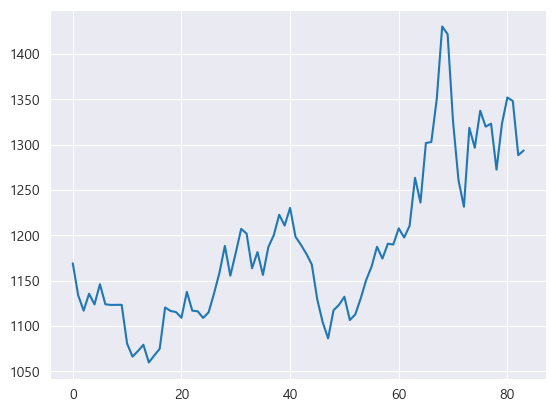

In [612]:
df_nickel['환율'].plot()

additive 모델


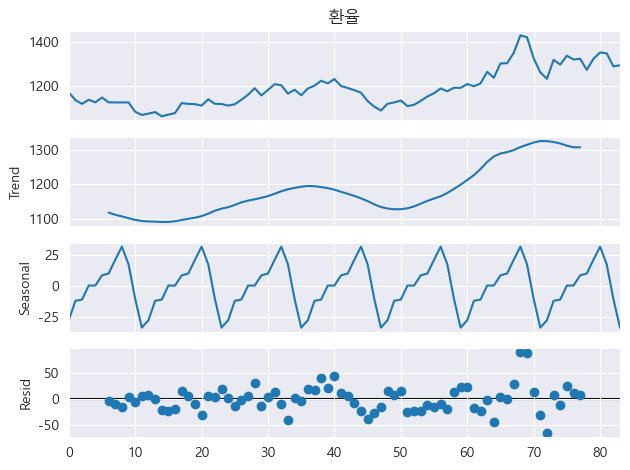

multiplicative 모델


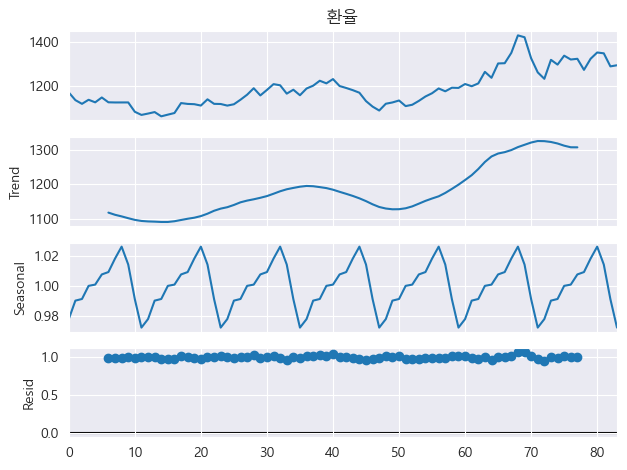

In [613]:
seasonal_decompose_graph(df_nickel, '환율', 12)

In [614]:
df_tmp, train, test = split_train_test(df_nickel, '환율')

03:48:04 - cmdstanpy - INFO - Chain [1] start processing
03:48:04 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 94.74150302783396
RMSE (Root Mean Squared Error): 107.08328958591224
MAPE (Mean Absolute Percentage Error): 7.17%


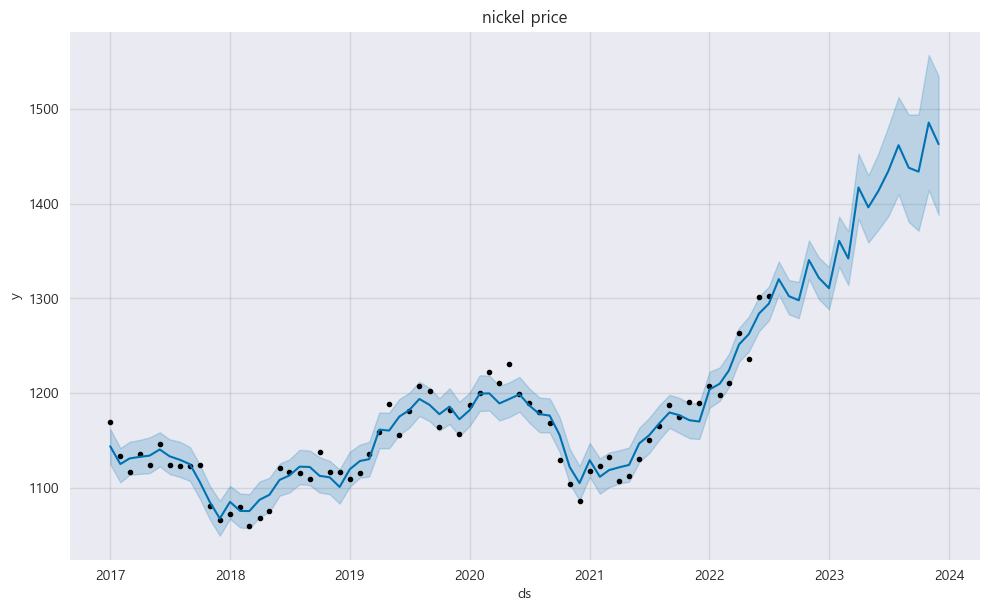

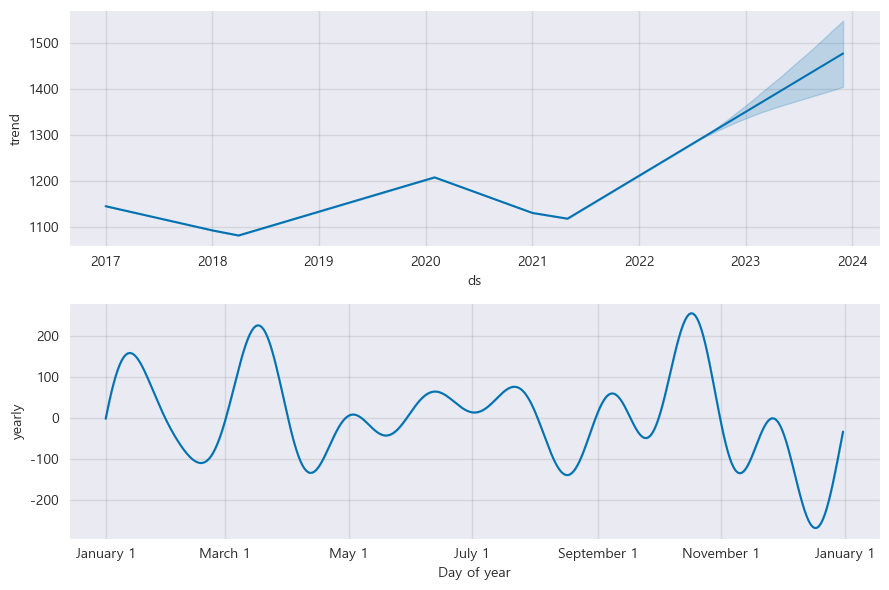

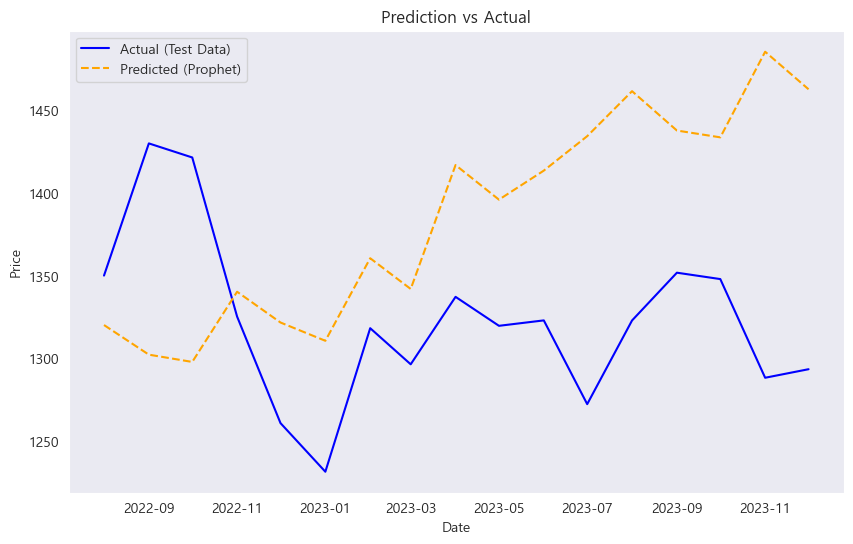

In [615]:
prophet_metrix_plot(train,test,'M')

#### 하이퍼파라미터 튜닝

In [616]:
# Grid Search를 위한 하이퍼파라미터 후보 설정
param_grid = {
    # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 2.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive']  
}

best_params = tune_prophet_parameters(param_grid, 'M')

03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing
03:48:49 - cmdstanpy - INFO - Chain [1] done processing
03:48:49 - cmdstanpy - INFO - Chain [1] start processing
03:48:49 - cmdstanpy - INFO - Chain [1] done processing
03:48:49 - cmdstanpy - INFO - Chain [1] start processing
03:48:49 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Best RMSE: 106.21316288772744


03:49:10 - cmdstanpy - INFO - Chain [1] start processing
03:49:11 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 95.27607984740312
RMSE (Root Mean Squared Error): 106.21316288772744
MAPE (Mean Absolute Percentage Error): 7.23%


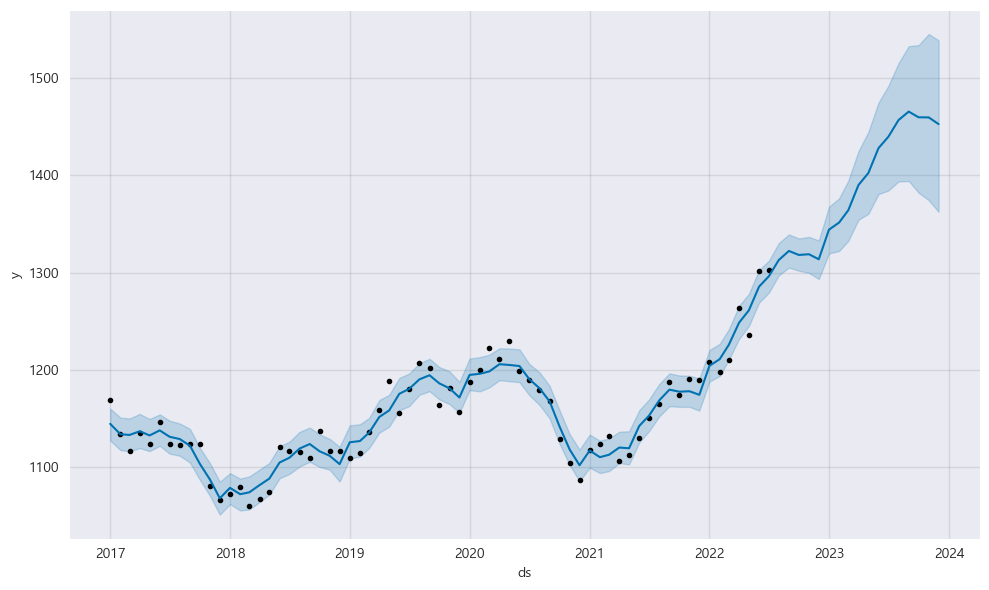

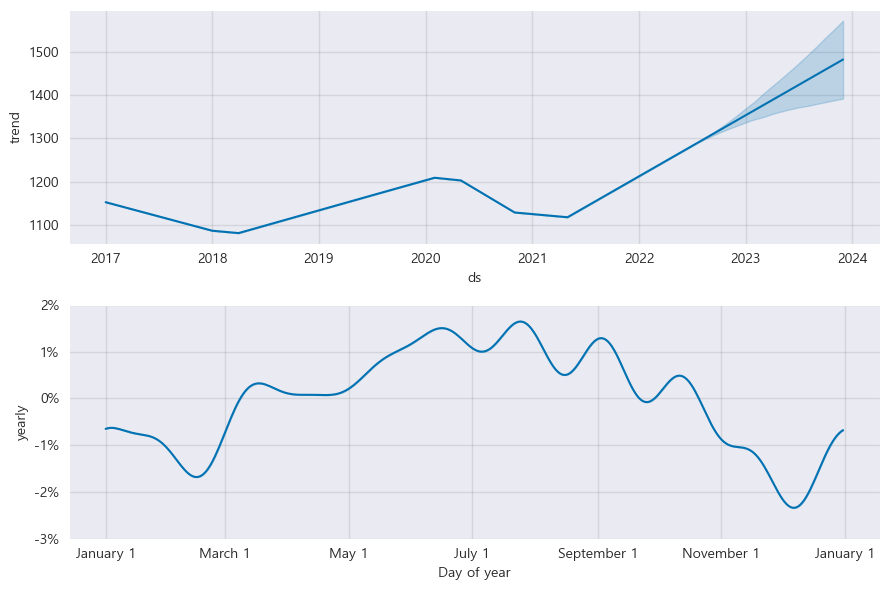

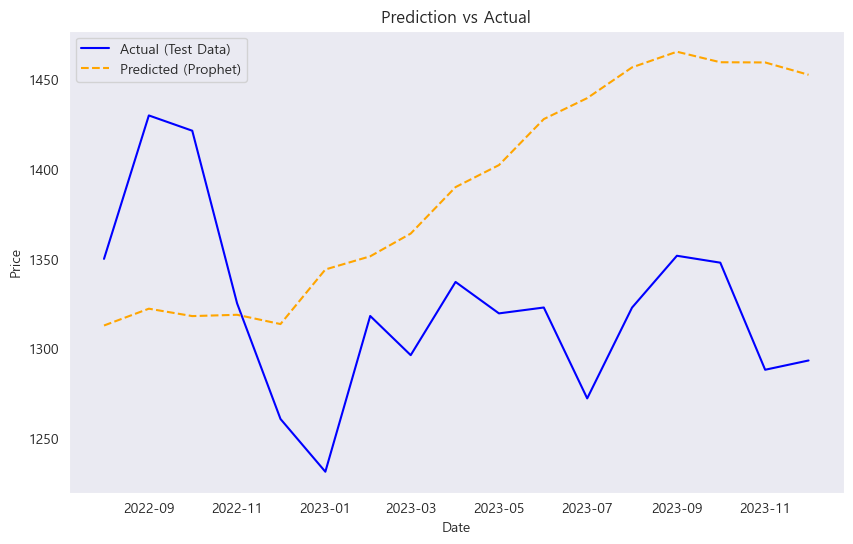

In [617]:
tune_prophet_parameters_plot(best_params, 'M')

#### 예측

03:49:38 - cmdstanpy - INFO - Chain [1] start processing
03:49:39 - cmdstanpy - INFO - Chain [1] done processing


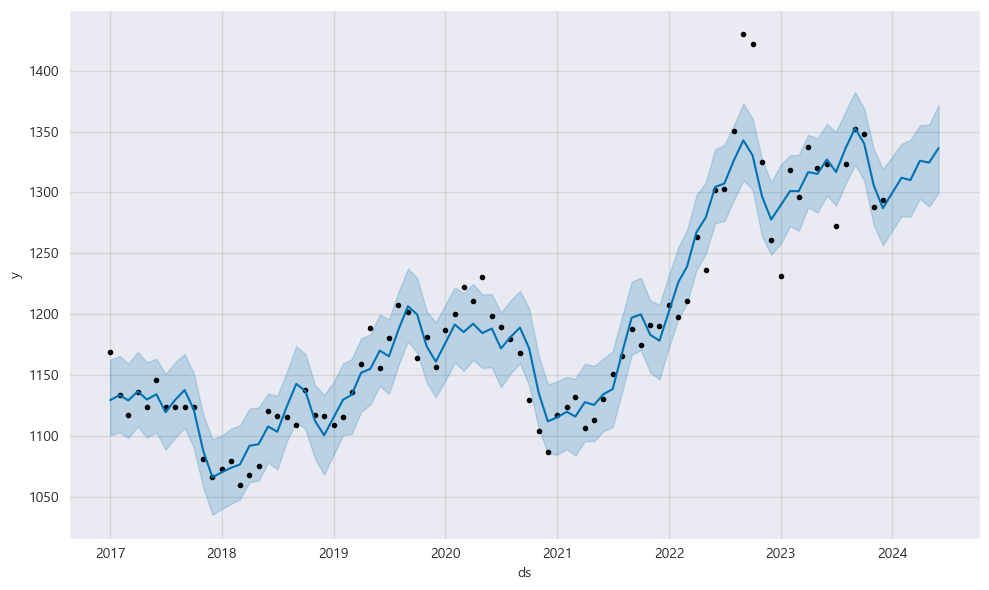

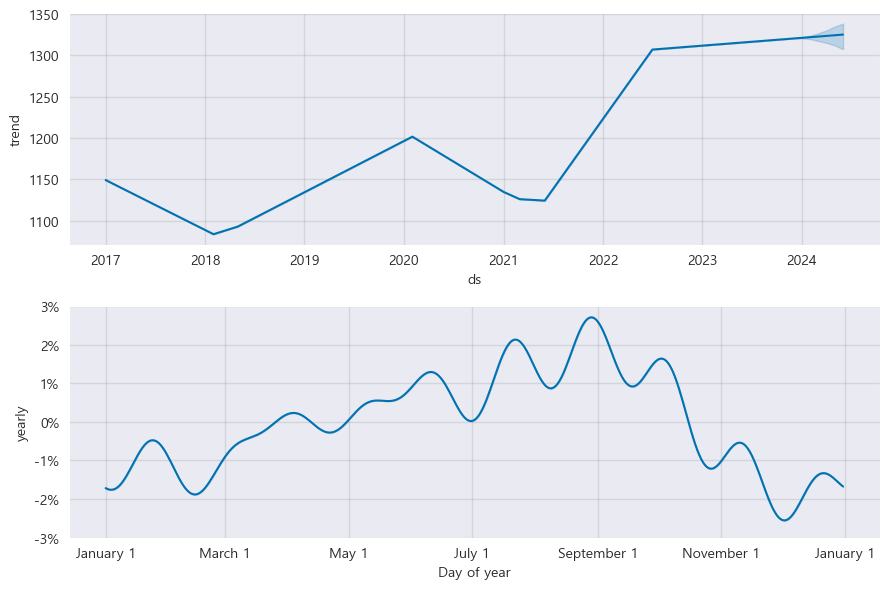

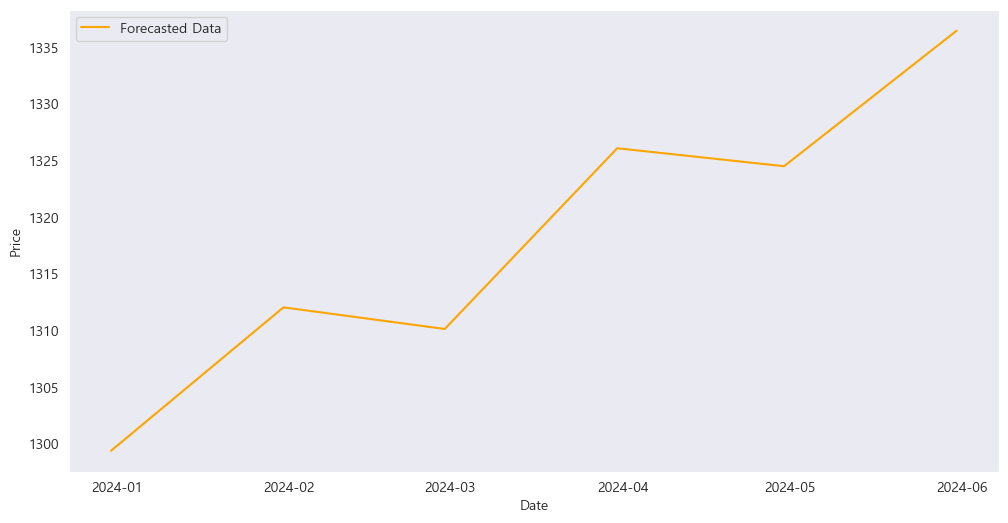

In [618]:
test_forecast = predict_2024(df_tmp, 6, 'M', 'orange')

In [619]:
test_forecast[['ds','yhat']]

,ds,yhat
84,2023-12-31,1299.423168
85,2024-01-31,1312.067204
86,2024-02-29,1310.160756
87,2024-03-31,1326.099107
88,2024-04-30,1324.515006
89,2024-05-31,1336.464376


In [620]:
df_er = test_forecast[['ds','yhat']]
df_er = df_er.rename(columns={'yhat':'환율'})

In [621]:
df_er

,ds,환율
84,2023-12-31,1299.423168
85,2024-01-31,1312.067204
86,2024-02-29,1310.160756
87,2024-03-31,1326.099107
88,2024-04-30,1324.515006
89,2024-05-31,1336.464376


In [622]:
df_2024_forecast['환율'] = df_er['환율']

In [623]:
df_2024_forecast

,ds,니켈가격,재고량,환율
84,2023-12-31,26407.799177,18266.115339,1299.423168
85,2024-01-31,26341.269069,14245.672769,1312.067204
86,2024-02-29,25330.735914,10283.731075,1310.160756
87,2024-03-31,25676.138077,5881.976931,1326.099107
88,2024-04-30,25634.629688,1733.431671,1324.515006
89,2024-05-31,24983.092002,-2537.615999,1336.464376


In [660]:
df_2024_forecast.to_csv('df_2024_forecast.csv',index=False)

### 생산량

In [698]:
production_consumption

,연도,생산량,소비량
0,2017,2065.960,2090.518
1,2018,2251.992,2339.103
2,2019,2430.243,2430.139
3,2020,2528.167,2442.837
4,2021,2784.683,2962.181
5,2022,3089.143,3003.505
6,2023,3429.284,3171.547


<Axes: >

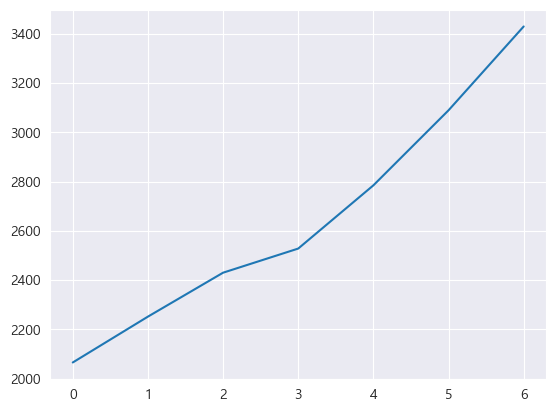

In [626]:
production_consumption['생산량'].plot()

additive 모델


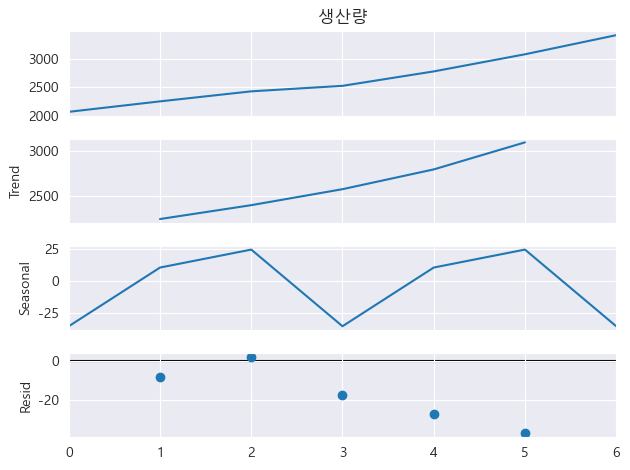

multiplicative 모델


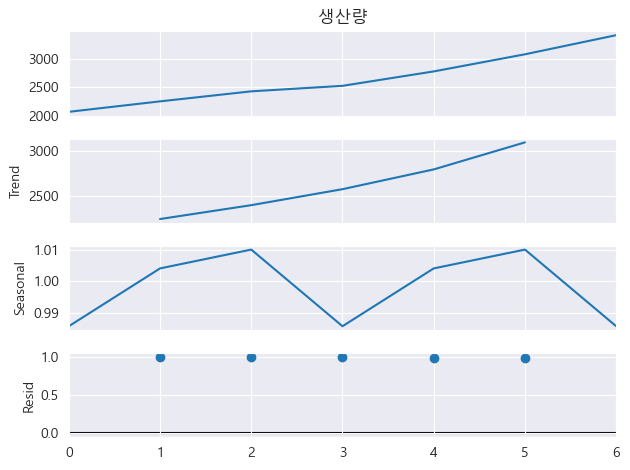

In [627]:
seasonal_decompose_graph(production_consumption, '생산량', 3)

In [641]:
df_tmp, train, test = split_train_test_production_consumption('생산량')

In [642]:
df_tmp

,ds,y
0,2017-01-01,2065.960
1,2018-01-01,2251.992
2,2019-01-01,2430.243
3,2020-01-01,2528.167
4,2021-01-01,2784.683
5,2022-01-01,3089.143
6,2023-01-01,3429.284


04:02:46 - cmdstanpy - INFO - Chain [1] start processing
04:02:46 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 565.7240377620064
RMSE (Root Mean Squared Error): 584.7363743782877
MAPE (Mean Absolute Percentage Error): 17.17%


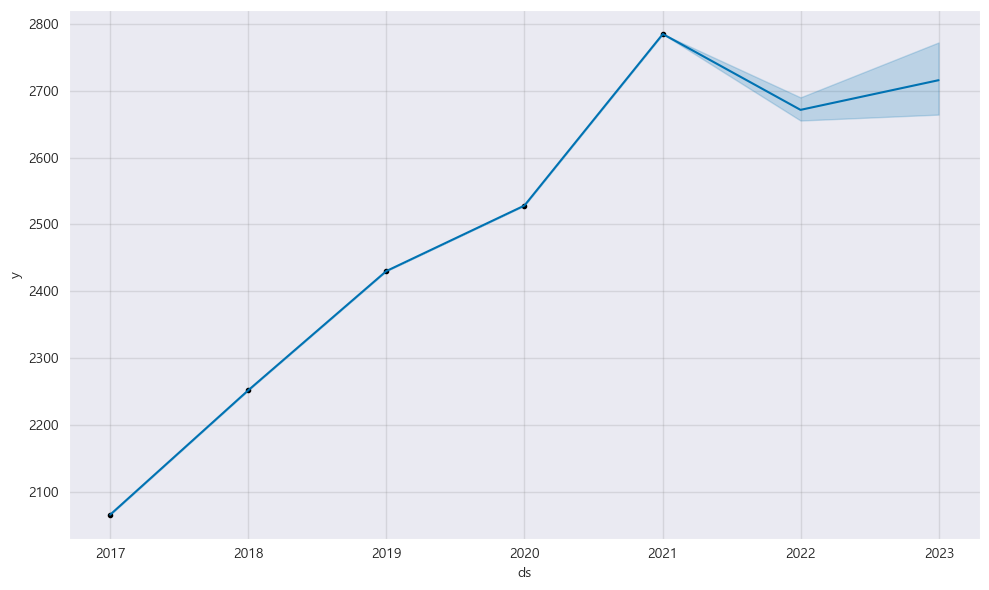

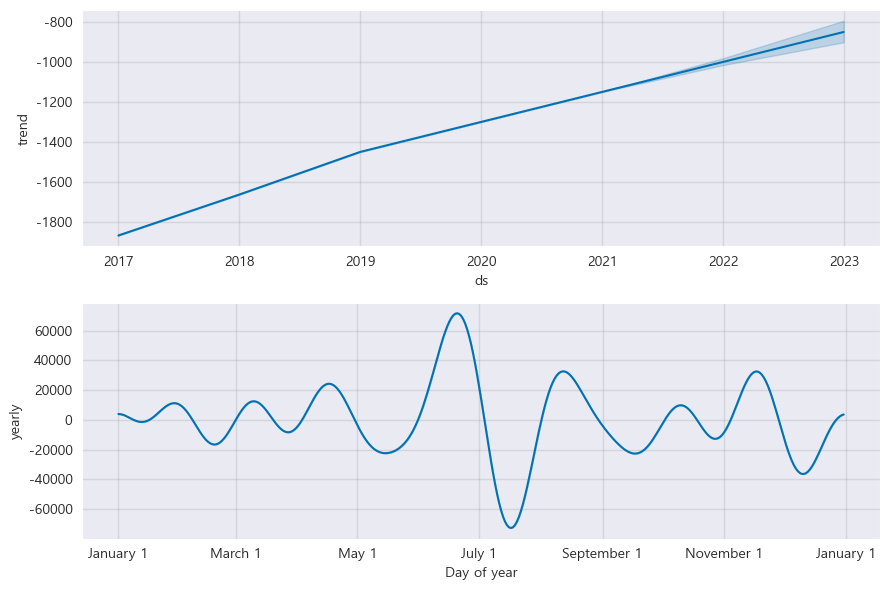

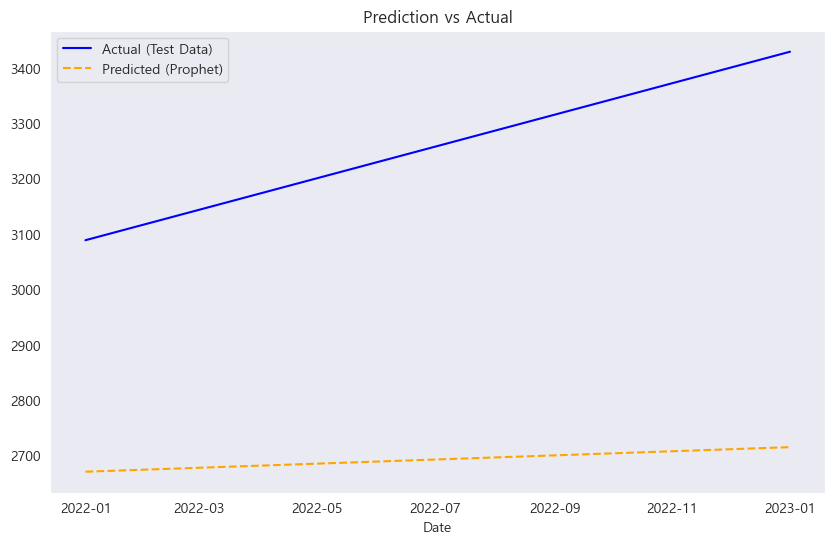

In [643]:
prophet_metrix_plot(train,test,'Y')

#### 하이퍼파라미터 튜닝

In [644]:
# Grid Search를 위한 하이퍼파라미터 후보 설정
param_grid = {
    # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 2.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive']  
}

best_params = tune_prophet_parameters(param_grid, 'Y')

04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:31 - cmdstanpy - INFO - Chain [1] done processing
04:03:31 - cmdstanpy - INFO - Chain [1] start processing
04:03:31 - cmdstanpy - INFO - Chain [1] done processing
04:03:31 - cmdstanpy - INFO - Chain [1] start processing
04:03:31 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 2.0, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Best RMSE: 100.68583688100927


04:06:44 - cmdstanpy - INFO - Chain [1] start processing
04:06:48 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 91.43883576981511
RMSE (Root Mean Squared Error): 100.68583688100927
MAPE (Mean Absolute Percentage Error): 2.75%


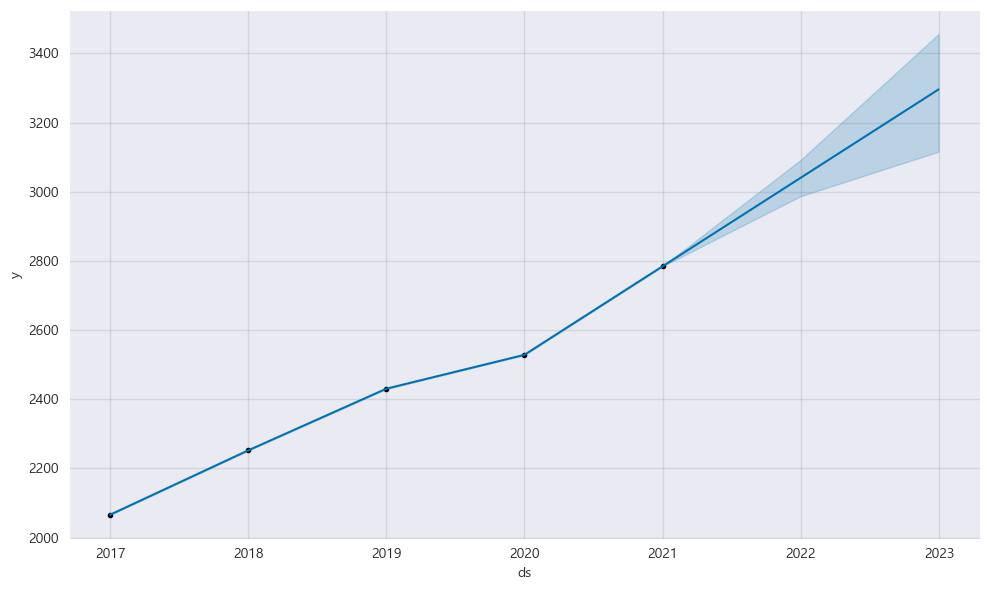

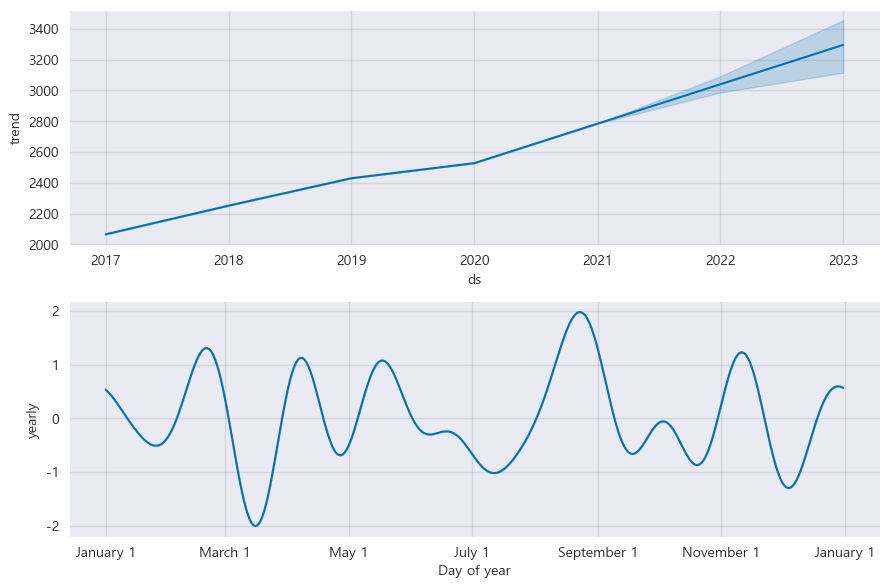

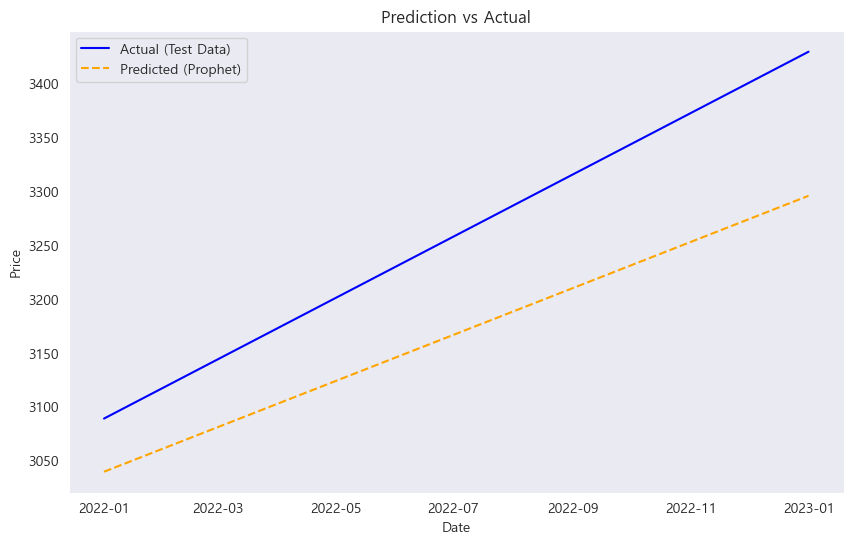

In [645]:
tune_prophet_parameters_plot(best_params, 'Y')

#### 예측

04:08:54 - cmdstanpy - INFO - Chain [1] start processing
04:08:54 - cmdstanpy - INFO - Chain [1] done processing


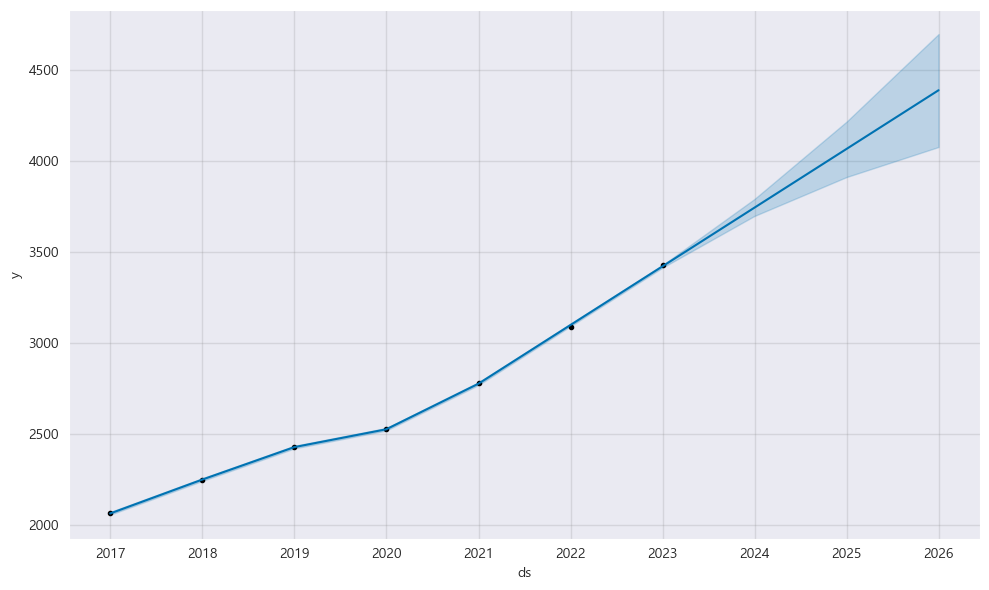

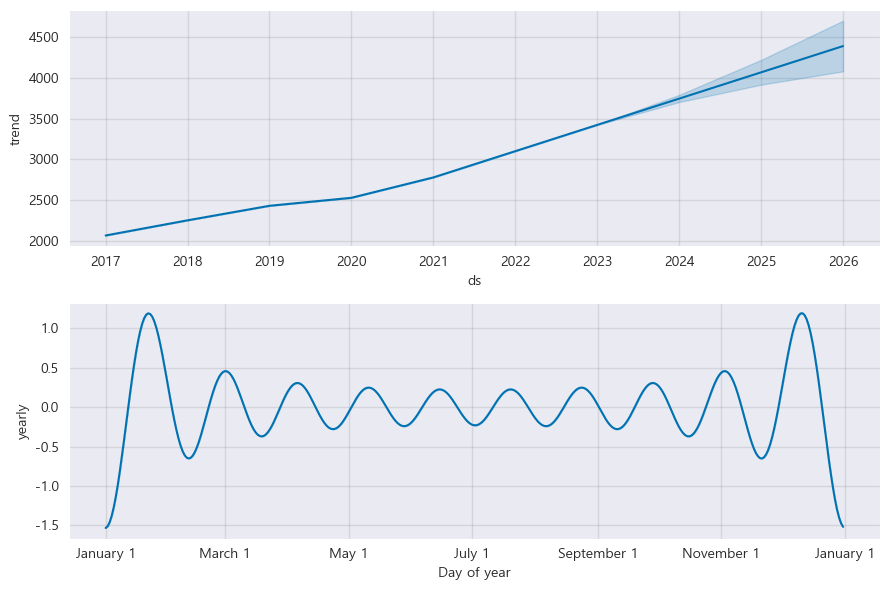

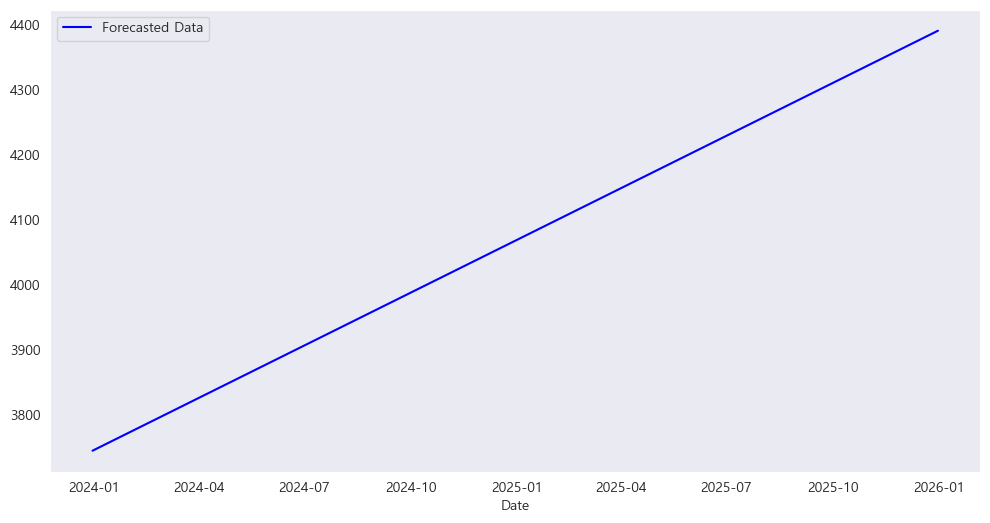

In [649]:
test_forecast = predict_2024(df_tmp, 3, 'Y', 'blue')

In [650]:
test_forecast[['ds','yhat']]

,ds,yhat
7,2023-12-31,3744.763171
8,2024-12-31,4067.907566
9,2025-12-31,4390.201870


In [658]:
df_consumption_production = test_forecast[['ds','yhat']]
df_consumption_production = df_consumption_production.rename(columns={'yhat':'생산량'})

In [659]:
df_consumption_production

,ds,생산량
7,2023-12-31,3744.763171
8,2024-12-31,4067.907566
9,2025-12-31,4390.201870


### 소비량

In [709]:
production_consumption

,연도,생산량,소비량
0,2017,2065.960,2090.518
1,2018,2251.992,2339.103
2,2019,2430.243,2430.139
3,2020,2528.167,2442.837
4,2021,2784.683,2962.181
5,2022,3089.143,3003.505
6,2023,3429.284,3171.547


<Axes: >

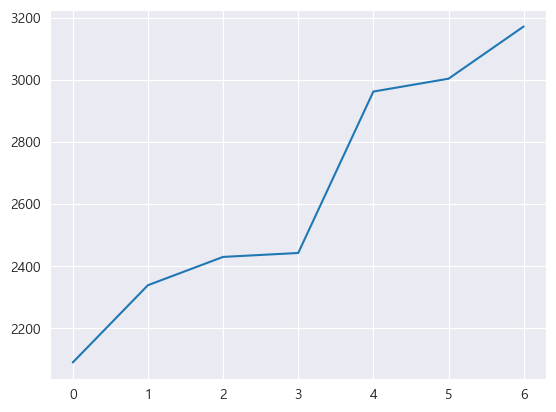

In [710]:
production_consumption['소비량'].plot()

additive 모델


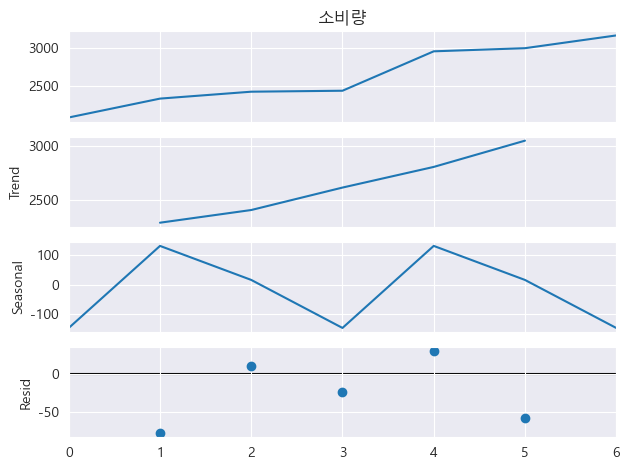

multiplicative 모델


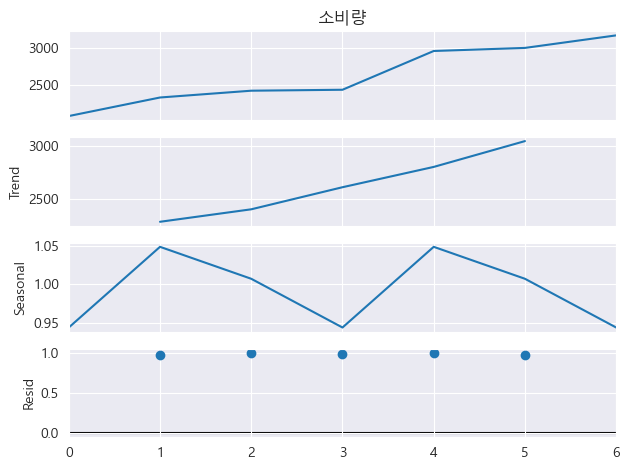

In [711]:
seasonal_decompose_graph(production_consumption, '소비량', 3)

In [712]:
df_tmp, train, test = split_train_test_production_consumption('소비량')

In [717]:
df_tmp

,ds,y
0,2017-01-01,2090.518
1,2018-01-01,2339.103
2,2019-01-01,2430.139
3,2020-01-01,2442.837
4,2021-01-01,2962.181
5,2022-01-01,3003.505
6,2023-01-01,3171.547


In [718]:
train

,ds,y
0,2017-01-01,2090.518
1,2018-01-01,2339.103
2,2019-01-01,2430.139
3,2020-01-01,2442.837
4,2021-01-01,2962.181


04:19:13 - cmdstanpy - INFO - Chain [1] start processing
04:19:14 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 1130.4572684550744
RMSE (Root Mean Squared Error): 1157.680650538961
MAPE (Mean Absolute Percentage Error): 36.42%


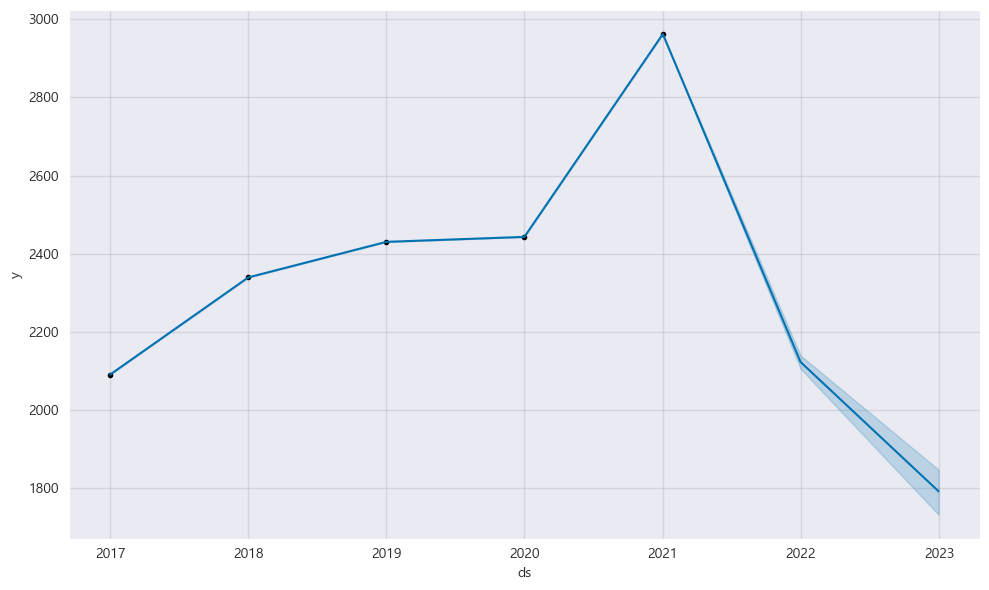

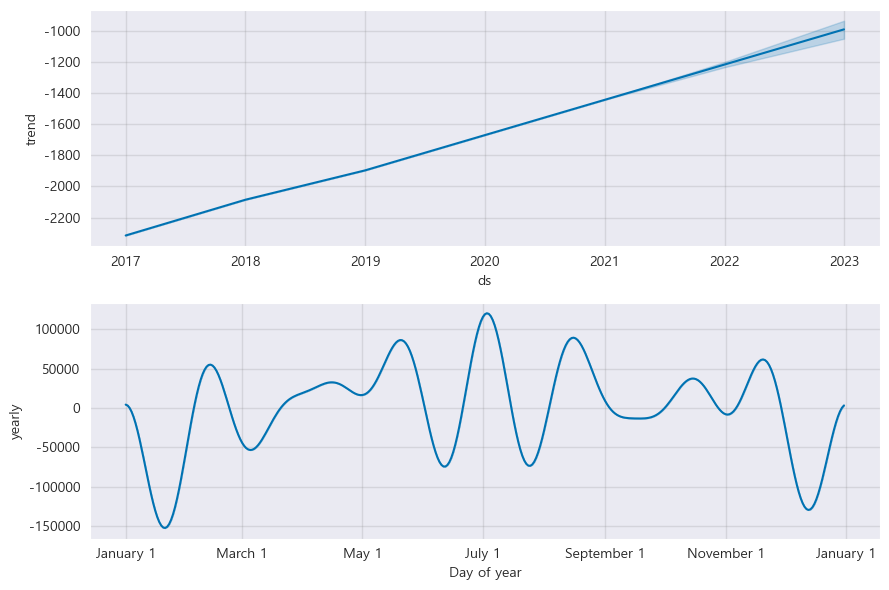

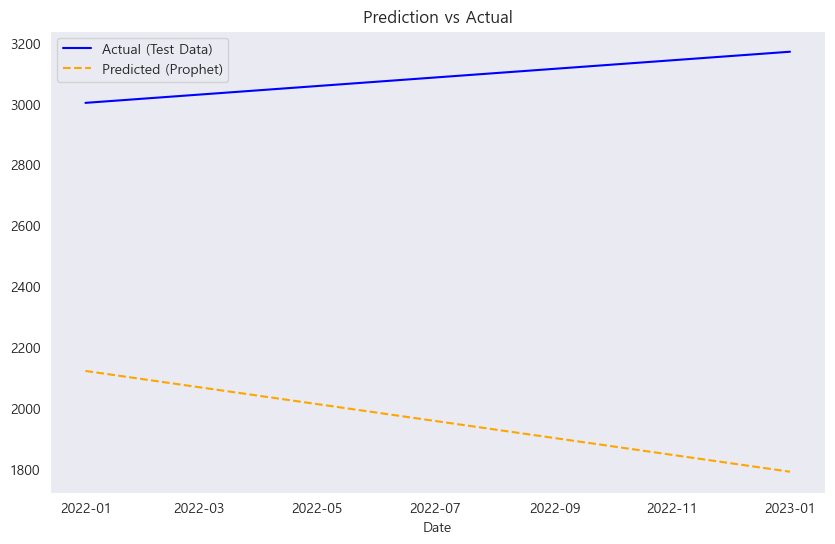

In [719]:
prophet_metrix_plot(train,test,'Y')

#### 하이퍼파라미터 튜닝

In [720]:
# Grid Search를 위한 하이퍼파라미터 후보 설정
param_grid = {
    # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 2.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive']  
}

best_params = tune_prophet_parameters(param_grid, 'Y')

04:19:58 - cmdstanpy - INFO - Chain [1] start processing
04:19:58 - cmdstanpy - INFO - Chain [1] done processing
04:19:58 - cmdstanpy - INFO - Chain [1] start processing
04:19:58 - cmdstanpy - INFO - Chain [1] done processing
04:19:58 - cmdstanpy - INFO - Chain [1] start processing
04:19:58 - cmdstanpy - INFO - Chain [1] done processing
04:19:59 - cmdstanpy - INFO - Chain [1] start processing
04:19:59 - cmdstanpy - INFO - Chain [1] done processing
04:19:59 - cmdstanpy - INFO - Chain [1] start processing
04:19:59 - cmdstanpy - INFO - Chain [1] done processing
04:19:59 - cmdstanpy - INFO - Chain [1] start processing
04:19:59 - cmdstanpy - INFO - Chain [1] done processing
04:19:59 - cmdstanpy - INFO - Chain [1] start processing
04:19:59 - cmdstanpy - INFO - Chain [1] done processing
04:19:59 - cmdstanpy - INFO - Chain [1] start processing
04:19:59 - cmdstanpy - INFO - Chain [1] done processing
04:19:59 - cmdstanpy - INFO - Chain [1] start processing
04:20:00 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}
Best RMSE: 12.478256567696299


04:22:53 - cmdstanpy - INFO - Chain [1] start processing
04:22:53 - cmdstanpy - INFO - Chain [1] done processing


MAE (Mean Absolute Error): 9.69284048327222
RMSE (Root Mean Squared Error): 12.478256567696299
MAPE (Mean Absolute Percentage Error): 0.31%


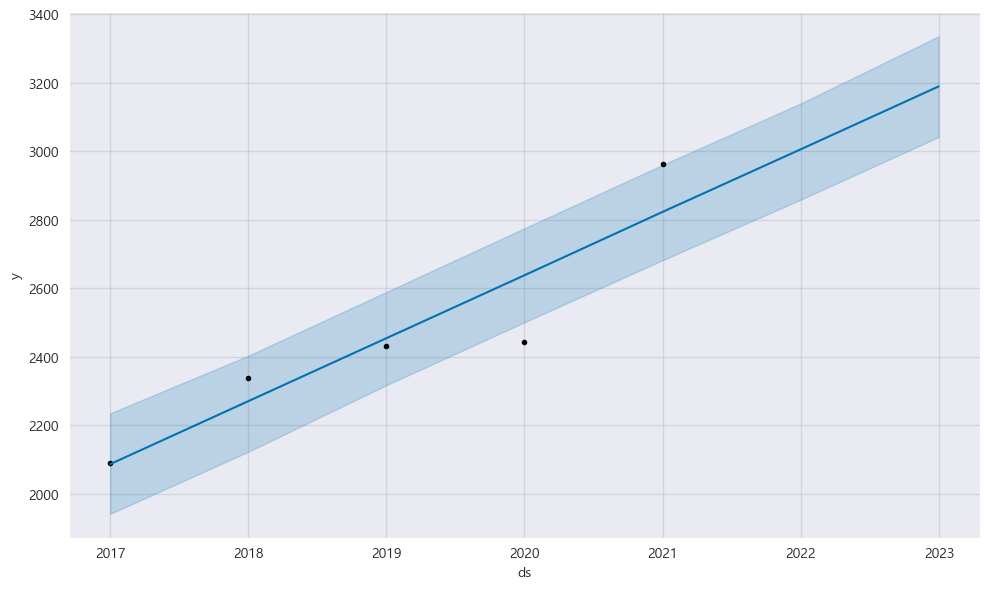

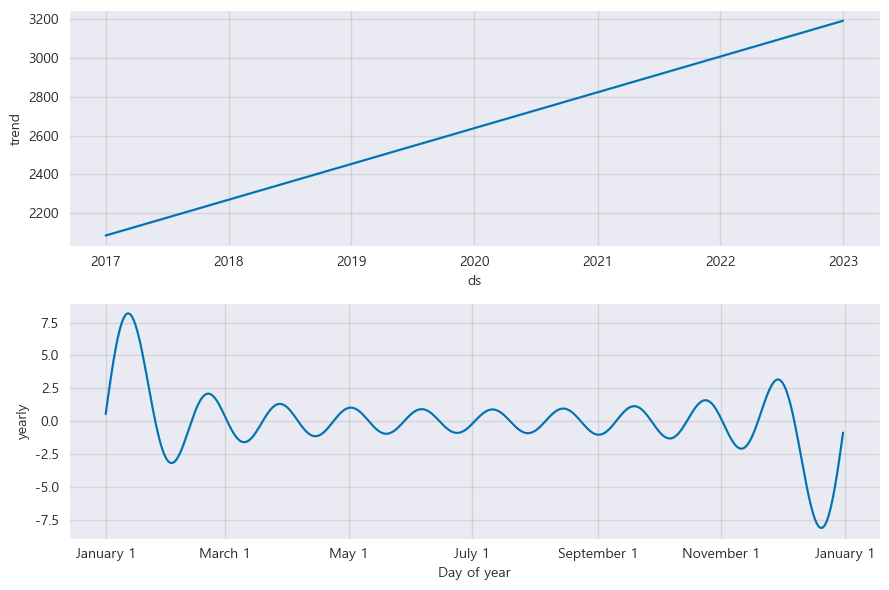

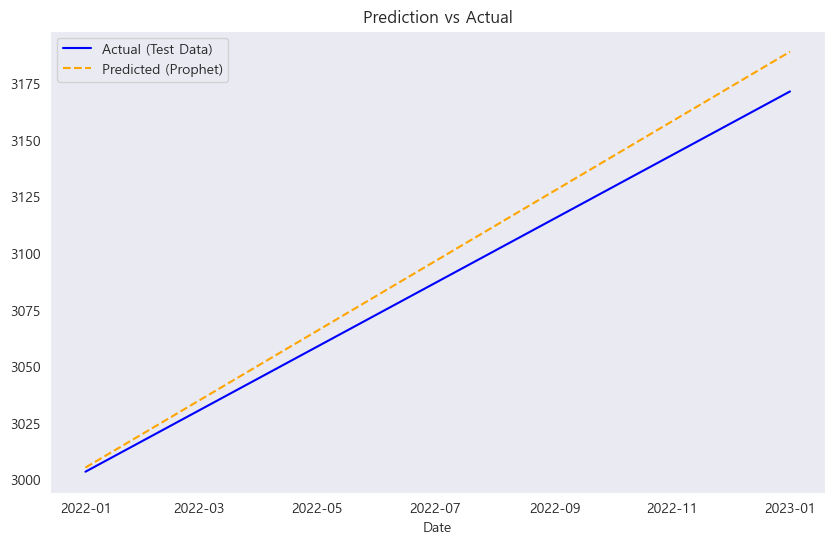

In [721]:
tune_prophet_parameters_plot(best_params, 'Y')

#### 예측

04:23:30 - cmdstanpy - INFO - Chain [1] start processing
04:23:30 - cmdstanpy - INFO - Chain [1] done processing


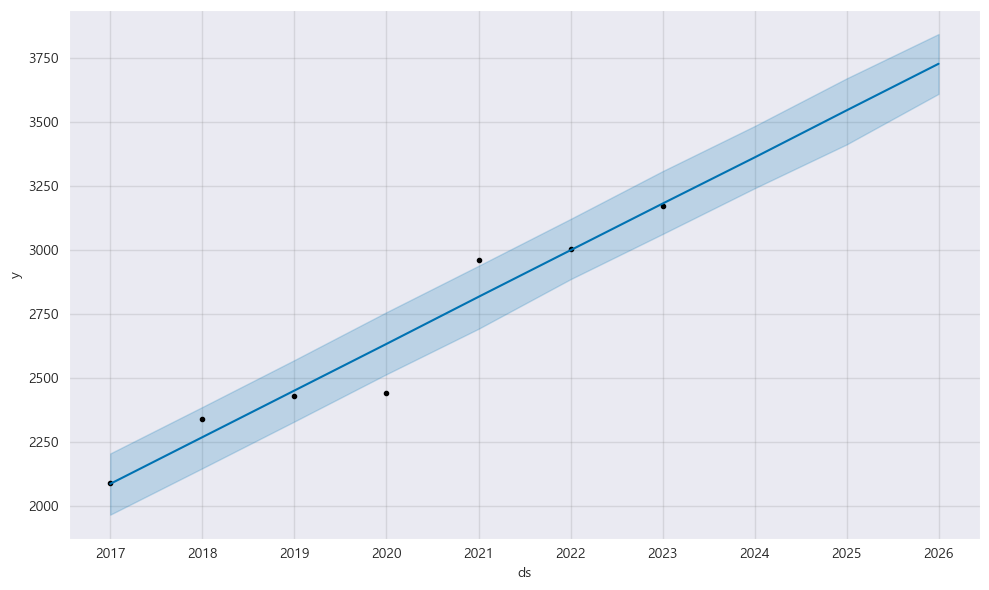

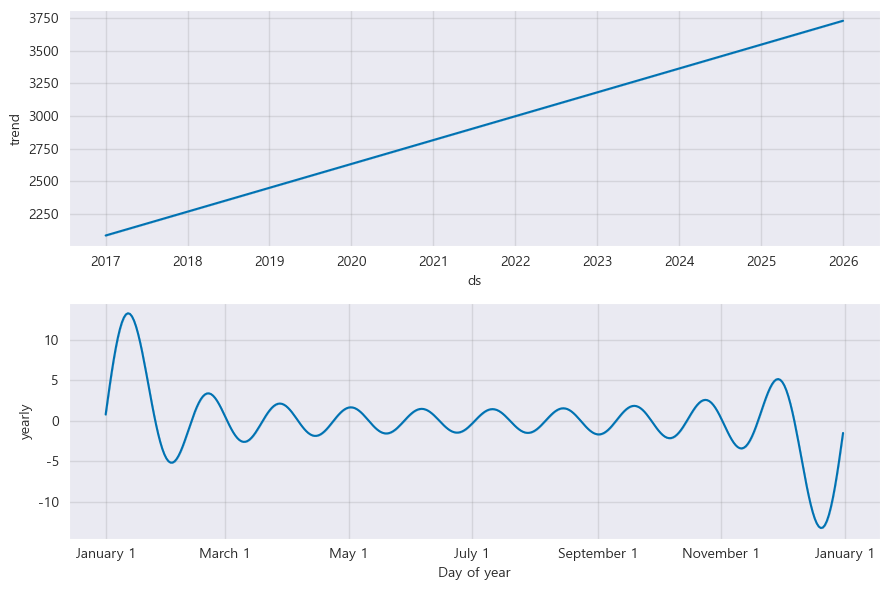

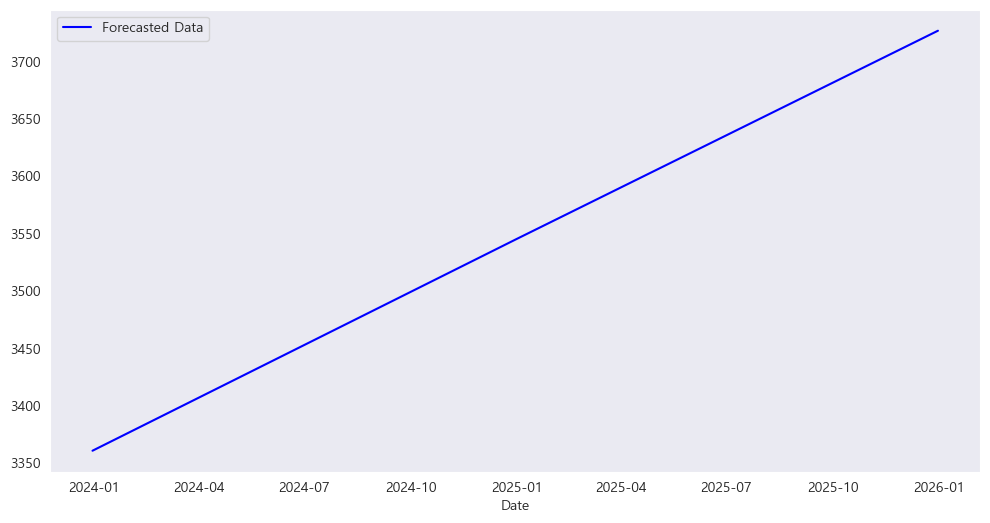

In [722]:
test_forecast = predict_2024(df_tmp, 3, 'Y', 'blue')

In [723]:
test_forecast[['ds','yhat']]

,ds,yhat
7,2023-12-31,3360.754555
8,2024-12-31,3544.931907
9,2025-12-31,3726.801247


In [724]:
df_consumption = test_forecast[['ds','yhat']]
df_consumption = df_consumption.rename(columns={'yhat':'소비량'})

In [725]:
df_consumption

,ds,소비량
7,2023-12-31,3360.754555
8,2024-12-31,3544.931907
9,2025-12-31,3726.801247


In [726]:
df_consumption_production['소비량'] = df_consumption['소비량']

In [727]:
df_consumption_production

,ds,생산량,소비량
7,2023-12-31,3744.763171,3360.754555
8,2024-12-31,4067.907566,3544.931907
9,2025-12-31,4390.201870,3726.801247


In [728]:
df_consumption_production.to_csv('df_2024_consumption_production.csv', index=False)